# Analysis of material properties of mitochondrial membranes

## Loading and setup

In [1]:
%load_ext autoreload


In [2]:
%matplotlib inline
%autoreload 1
import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

from scipy import integrate, interpolate, stats
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

%aimport util
from plot_helper import *


Matplotlib Version: 3.6.3


In [3]:
plot_styles = [
    ("./white_background_ctl.mplstyle", ""),
    ("./dark_background_ctl.mplstyle", "_dark"),
]


# Lateral Pressures

In [4]:
def first_cubic_np(z, lp, minz=None, maxz=None, maxiter=5000, sym: bool = True):
    """
    Compute the first moment using a cubic piecewise interpolant and Gaussian quadrature
    """
    lp = lp / 1e3  # to convert to piconewtons / nm^2

    if sym:
        if len(lp) % 2 == 1:
            s = int(np.floor(len(lp) / 2))
            bot, mid, top = np.split(lp, [s, s + 1])
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, mid, sym_top))
        else:
            bot, top = np.split(lp, 2)
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, sym_top))

    y = lp * z

    if minz is None:
        minz = min(z)
    if maxz is None:
        maxz = max(z)

    approx = interpolate.interp1d(z, y, kind="cubic")  # interpolating a function
    intg = integrate.quadrature(
        approx, minz, maxz, maxiter=maxiter
    )  # finding the integral over bounds
    return intg


def zero_cubic_np(z, lp, minz=None, maxz=None, maxiter=5000, sym: bool = True):
    """
    Compute the zeroeth moment using a cubic piecewise interpolant and Gaussian quadrature
    """
    # p = data['LP_(kPA)']/1e15 # to convert to newtons / nm^2
    lp = lp / 1e3  # to convert to piconewtons / nm^2

    if sym:
        if len(lp) % 2 == 1:
            s = int(np.floor(len(lp) / 2))
            bot, mid, top = np.split(lp, [s, s + 1])
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, mid, sym_top))
        else:
            bot, top = np.split(lp, 2)
            sym_top = (np.flip(bot) + top) / 2
            sym_bot = np.flip(sym_top)
            lp = np.hstack((sym_bot, sym_top))

    if minz is None:
        minz = min(z)
    if maxz is None:
        maxz = max(z)

    approx = interpolate.interp1d(z, lp, kind="cubic")  # interpolating a function
    intg = integrate.quadrature(
        approx, minz, maxz, maxiter=maxiter
    )  # finding the integral over bounds
    return intg


def mean_squared_deviation_np(data: npt.ArrayLike) -> float:
    """
    Compute the mean squared deviation of the data
    """
    return sum(data**2) / (data.size - 1)


def max_difference(a: npt.ArrayLike, b: npt.ArrayLike):
    """
    Get the max difference between two equal sized arrays
    """
    if a.size != b.size:
        raise RuntimeError("a and b must be same sized arrays")
    diff = np.abs(a - b)
    return np.amax(diff)


In [5]:
from LStensor import LStensor


# Override and recompute even if spectra pickle exists
lp_compute_override = False

lp_fd = util.analysis_path / "lp.pickle"


if lp_fd.exists() and not lp_compute_override:
    # LOAD LP pickle
    with open(lp_fd, "rb") as handle:
        lateral_pressure = pickle.load(handle)
    print("Loaded LP from cache")

else:
    lateral_pressure = {}

    for sim in util.simulations:
        fd = Path(util.analysis_path / f"{sim}_small/stress_calc/frames/frame0.dat0")
        field = LStensor(2)
        field.g_loaddata(files=[fd], bAvg="avg")

        # stress_tensor = np.empty((20000, field.nz, 9))
        lateral_pressure[sim] = np.empty((40000, field.nz, 3))

        # 0-20000 frames in each trajectory
        for i, j in enumerate(range(1, 40001)):
            fd = Path(
                util.analysis_path / f"{sim}_small/stress_calc/frames/frame{j}.dat0"
            )
            field = LStensor(2)
            field.g_loaddata(files=[fd], bAvg="avg")
            stress_tensor = field.data_grid * 100  # Convert to kPa from 10^5 Pa
            # Sxx Sxy Sxz Syx Syy Syz Szx Szy Szz
            # 0               4               8

            pXY = -0.5 * (stress_tensor[:, 0] + stress_tensor[:, 4]).reshape(-1, 1)
            pN = (-stress_tensor[:, 8]).reshape(-1, 1)
            lp = pXY - pN
            z = (
                np.arange(field.nz) * field.dz - (field.nz - 1) * field.dz / 2
            ).reshape(-1, 1)
            lateral_pressure[sim][i] = np.hstack((pN, lp, z))

    # WRITE LP TO PICKLE
    with open(lp_fd, "wb") as handle:
        pickle.dump(lateral_pressure, handle, protocol=pickle.HIGHEST_PROTOCOL)


Loaded LP from cache


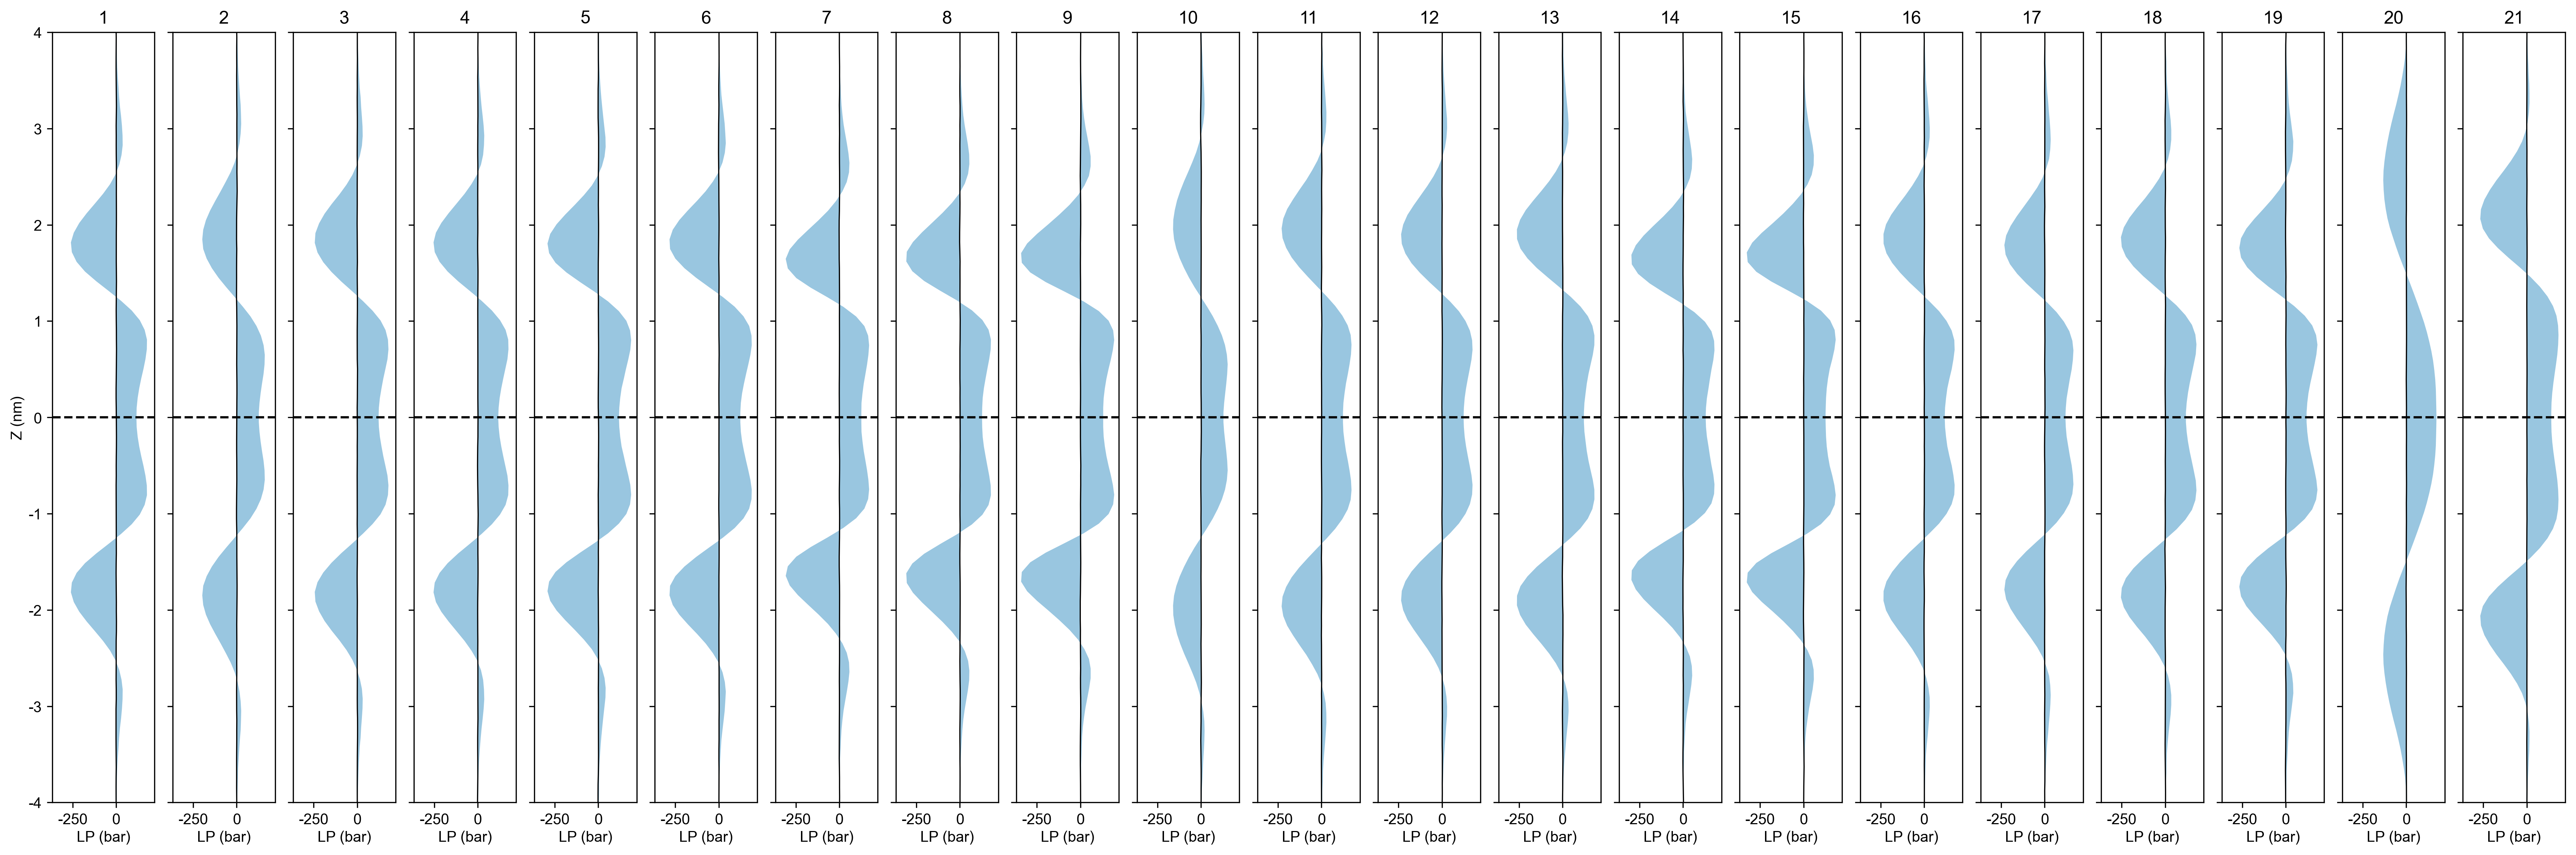

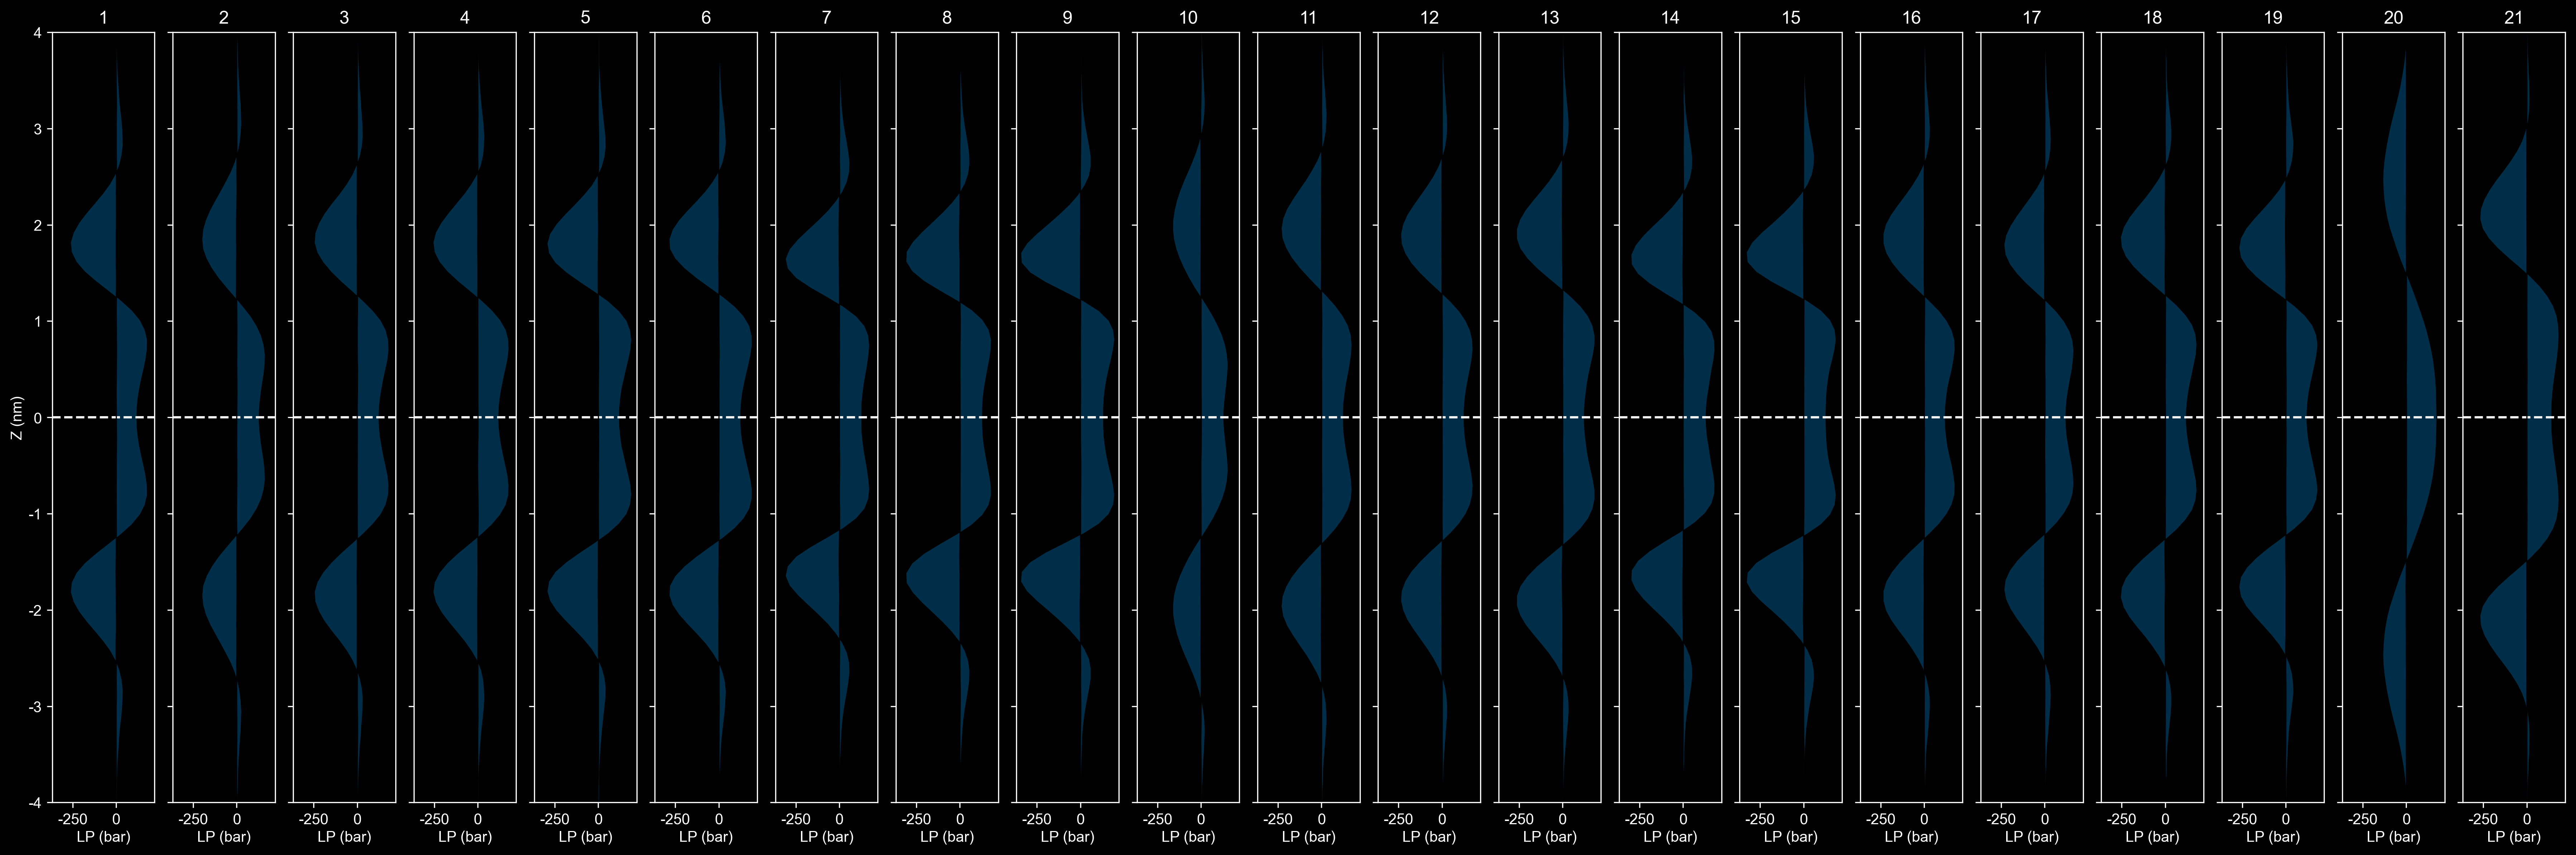

In [6]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

k = 3


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"


        fig, ax = plt.subplots(
            1, len(util.remapping_order), figsize=(24, 8), sharex=True, sharey=True
        )
        for sim_new in range(1, len(util.remapping_order) + 1):
            ax_index = int(sim_new) - 1
            sim = util.remapping_dict[sim_new]

            ax[ax_index].axhline(0, linestyle="--", color=ecolor)

            # k_fold_data = np.array_split(lateral_pressure[sim], k, axis=0)

            # split_data = []
            # for split in k_fold_data:
            #     # print(split.shape)
            #     split_data.append(np.mean(split, axis=0))

            data = np.mean(lateral_pressure[sim], axis=0)

            # for data in split_data:
            z = data[:, 2]

            ax[ax_index].plot(
                data[:, 0] * 0.01,
                z,
                label="Normal Stress",
                linewidth=NORMAL_LINE,
                linestyle="-",
                color="k",
            )

            lateral = data[:, 1] * 0.01  # bar

            # Symmetrizing
            if len(lateral) % 2 == 1:
                s = int(np.floor(len(lateral) / 2))
                bot, mid, top = np.split(lateral, [s, s + 1])
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, mid, sym_top))
            else:
                bot, top = np.split(lateral, 2)
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, sym_top))

                # ax[ax_index].plot(
                #     sym_lp,
                #     z,
                #     label="Lateral Pressure",
                #     linewidth=NORMAL_LINE,
                #     linestyle="-",
                # )  # alpha=0.4,

            ax[ax_index].fill_betweenx(z, sym_lp, 0, label="Lateral Pressure", alpha=0.4)

            ax[ax_index].set_ylim(-4, 4)
            # ax[x,y].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
            ax[ax_index].set_xlabel("LP (bar)")
            ax[ax_index].set_title(f"{sim_new}")
            if ax_index == 0:
                ax[ax_index].set_ylabel("Z (nm)")

        # handles = [
        #     mlines.Line2D([], [], color="black", linestyle=":", label="Normal Stress"),
        #     mlines.Line2D(
        #         [],
        #         [],
        #         color="black",
        #         linestyle="-",
        #         label="Lateral Stress",
        #     ),
        # ]

        # plt.legend(handles=handles, bbox_to_anchor=(-2.5, -0.95, 0.8, 0.8), ncol=2)
        plt.tight_layout()

        save_fig(fig, curr_fig_path / f"stress{style_ext}")
        
        if show_figs:
            plt.show()
        fig.clear()
        plt.close(fig)


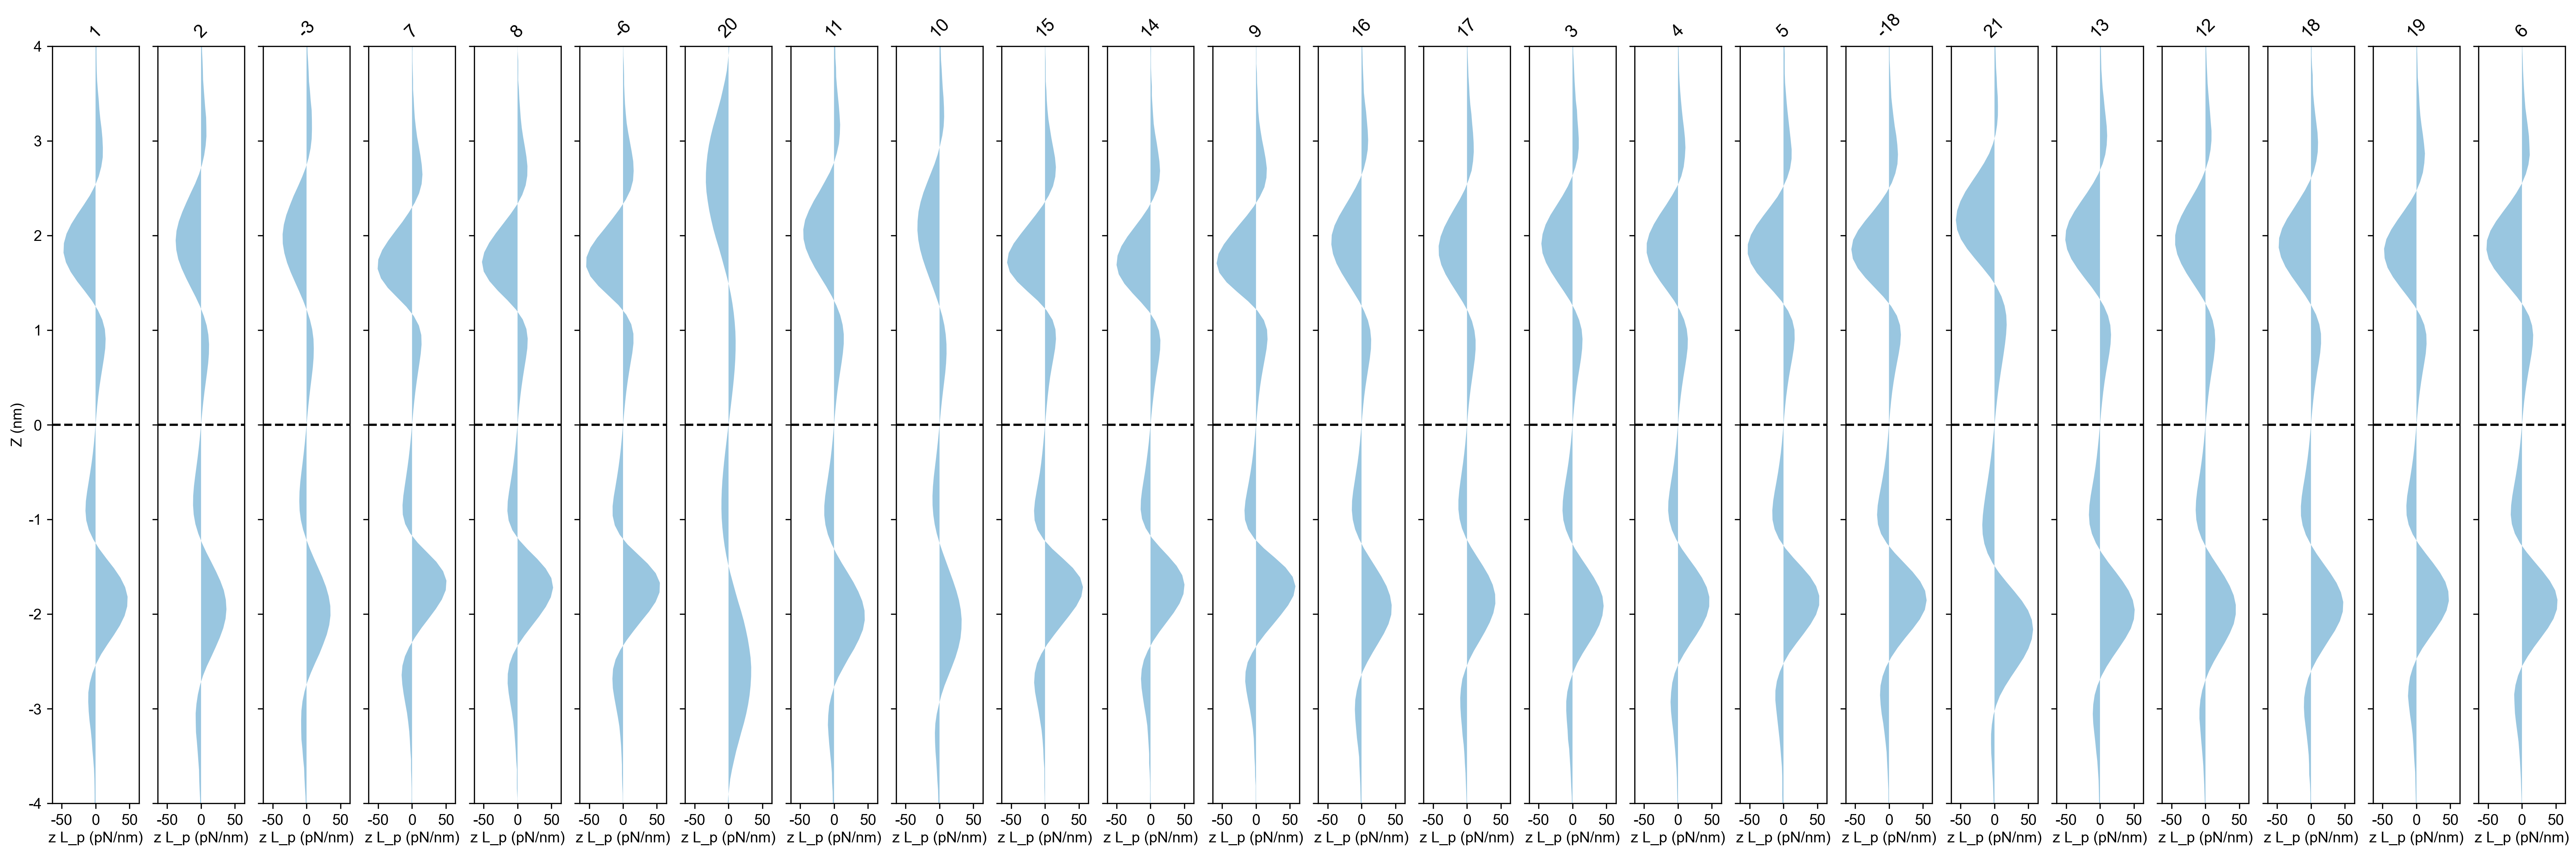

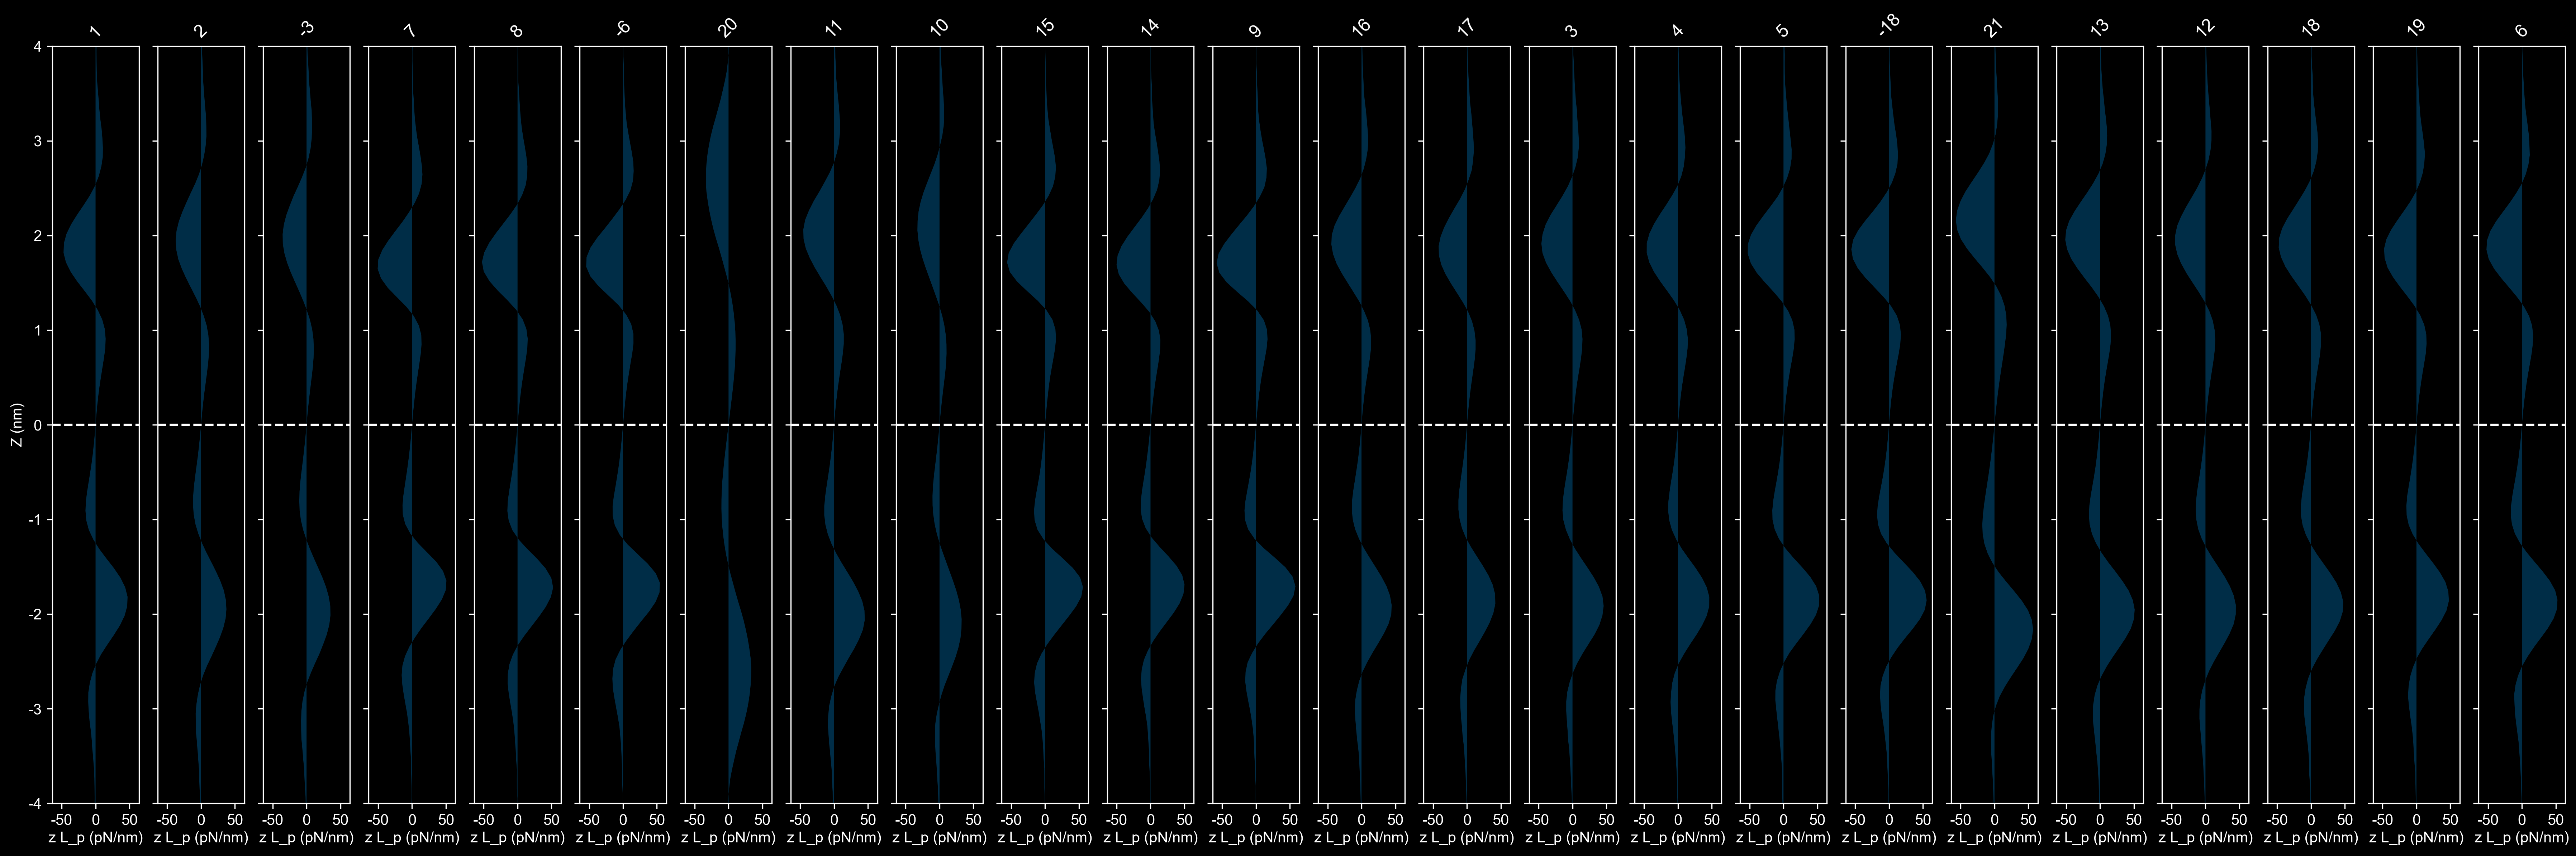

In [7]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"


        fig, ax = plt.subplots(1, 24, figsize=(24, 8), sharex=True, sharey=True)
        for sim in util.simulations:
            ax_index = int(sim) - 1
            ax[ax_index].axhline(0, linestyle="--", color=ecolor)

            data = np.mean(lateral_pressure[sim], axis=0)
            z = data[:, 2]

            lateral = data[:, 1] / 1e3  # pN/nm^2
            # Symmetrizing
            if len(lateral) % 2 == 1:
                s = int(np.floor(len(lateral) / 2))
                bot, mid, top = np.split(lateral, [s, s + 1])
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, mid, sym_top))
            else:
                bot, top = np.split(lateral, 2)
                sym_top = (np.flip(bot) + top) / 2
                sym_bot = np.flip(sym_top)
                sym_lp = np.hstack((sym_bot, sym_top))

            ax[ax_index].fill_betweenx(z, z * sym_lp, 0, label="Lateral Stress", alpha=0.4)

            ax[ax_index].set_ylim(-4, 4)
            # ax[x,y].ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
            ax[ax_index].set_xlabel("z L_p (pN/nm)")
            ax[ax_index].set_title(f"{util.sim_to_final_index[sim]}", rotation=45)
            if ax_index == 0:
                ax[ax_index].set_ylabel("Z (nm)")

        # handles = [
        #     mlines.Line2D([], [], color="black", linestyle=":", label="Normal Stress"),
        #     mlines.Line2D(
        #         [],
        #         [],
        #         color="black",
        #         linestyle="-",
        #         label="Lateral Stress",
        #     ),
        # ]

        # plt.legend(handles=handles, bbox_to_anchor=(-2.5, -0.95, 0.8, 0.8), ncol=2)
        plt.tight_layout()

        save_fig(fig, curr_fig_path / f"first_mom_integrand{style_ext}")

        if show_figs:
            plt.show()
        fig.clear()
        plt.close(fig)


In [8]:


show_figs = False

k = 3  # Number of sections to split data into

f_cubic_dat = {}
z_cubic_dat = {}
msd_dat = {}

for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"

        for sim in util.simulations:
            k_fold_data = np.array_split(lateral_pressure[sim], k, axis=0)

            data = []
            for split in k_fold_data:
                # print(split.shape)
                data.append(np.mean(split, axis=0))

            # fig, ax = plt.subplots(1, 1, figsize=(8, 8))

            fcd = np.zeros(k)
            for i, d in enumerate(data):
                z = d[:, 2]
                lateral = d[:, 1]

                # Symmetrizing
                if len(lateral) % 2 == 1:
                    s = int(np.floor(len(lateral) / 2))
                    bot, mid, top = np.split(lateral, [s, s + 1])
                    sym_top = (np.flip(bot) + top) / 2
                    sym_bot = np.flip(sym_top)
                    sym_lp = np.hstack((sym_bot, mid, sym_top))
                else:
                    bot, top = np.split(lateral, 2)
                    sym_top = (np.flip(bot) + top) / 2
                    sym_bot = np.flip(sym_top)
                    sym_lp = np.hstack((sym_bot, sym_top))

                # ax.plot(sym_lp, z, label="Lateral Pressure", alpha=0.4)

                fcd[i] = (
                    first_cubic_np(z, sym_lp, maxz=0)[0] - first_cubic_np(z, sym_lp, minz=0)[0]
                ) / 2
            f_cubic_dat[sim] = (np.mean(fcd), np.std(fcd))
            print(sim, fcd, f_cubic_dat[sim])

            # ax.set_ylim(-4, 4)

            # plt.tight_layout()

            # save_fig(fig, curr_fig_path / f"first_mom_integrand{style_ext}")

            # if show_figs:
            #     plt.show()
            # fig.clear()
            # plt.close(fig)


1 [16.59469922 14.55668819 16.94720107] (16.03286282437595, 1.0536865621641713)
2 [17.52726536 15.83330157 18.26359158] (17.20805283906782, 1.0175132614673912)
3 [14.40764142 16.55763774 15.77397017] (15.579749778219139, 0.8884113996045878)
4 [13.3438027  12.4423631  12.62415984] (12.803441878734608, 0.38923418458540543)
5 [15.24026407 14.74404498 14.96380343] (14.98270415952958, 0.20302097290977134)
6 [12.62684218 13.15516208 15.95883532] (13.913613195348134, 1.4621857253141024)
7 [35.42594531 33.34649389 35.18818992] (34.65354304080213, 0.929306198632866)
8 [20.64406544 21.68749991 21.20471021] (21.178758520273263, 0.42637541322155437)
9 [19.76523808 19.94536227 19.81329367] (19.84129800631053, 0.07615494354665889)
10 [14.15602489 15.78044644 15.60508639] (15.180519240533705, 0.727955718565714)
11 [13.44672772 13.99581197 16.52223739] (14.654925696753708, 1.3392816737315514)
12 [18.68183714 17.17615513 14.71095189] (16.85631471842346, 1.6368070225401494)
13 [20.77317152 20.72250358 1

In [9]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys

    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


pal = sns.color_palette("colorblind")
bar_props = [
    (1, 1, None),
    (3, 1, None),
    (2, 1.1, None),
    (2, 0.95, "///"),
]


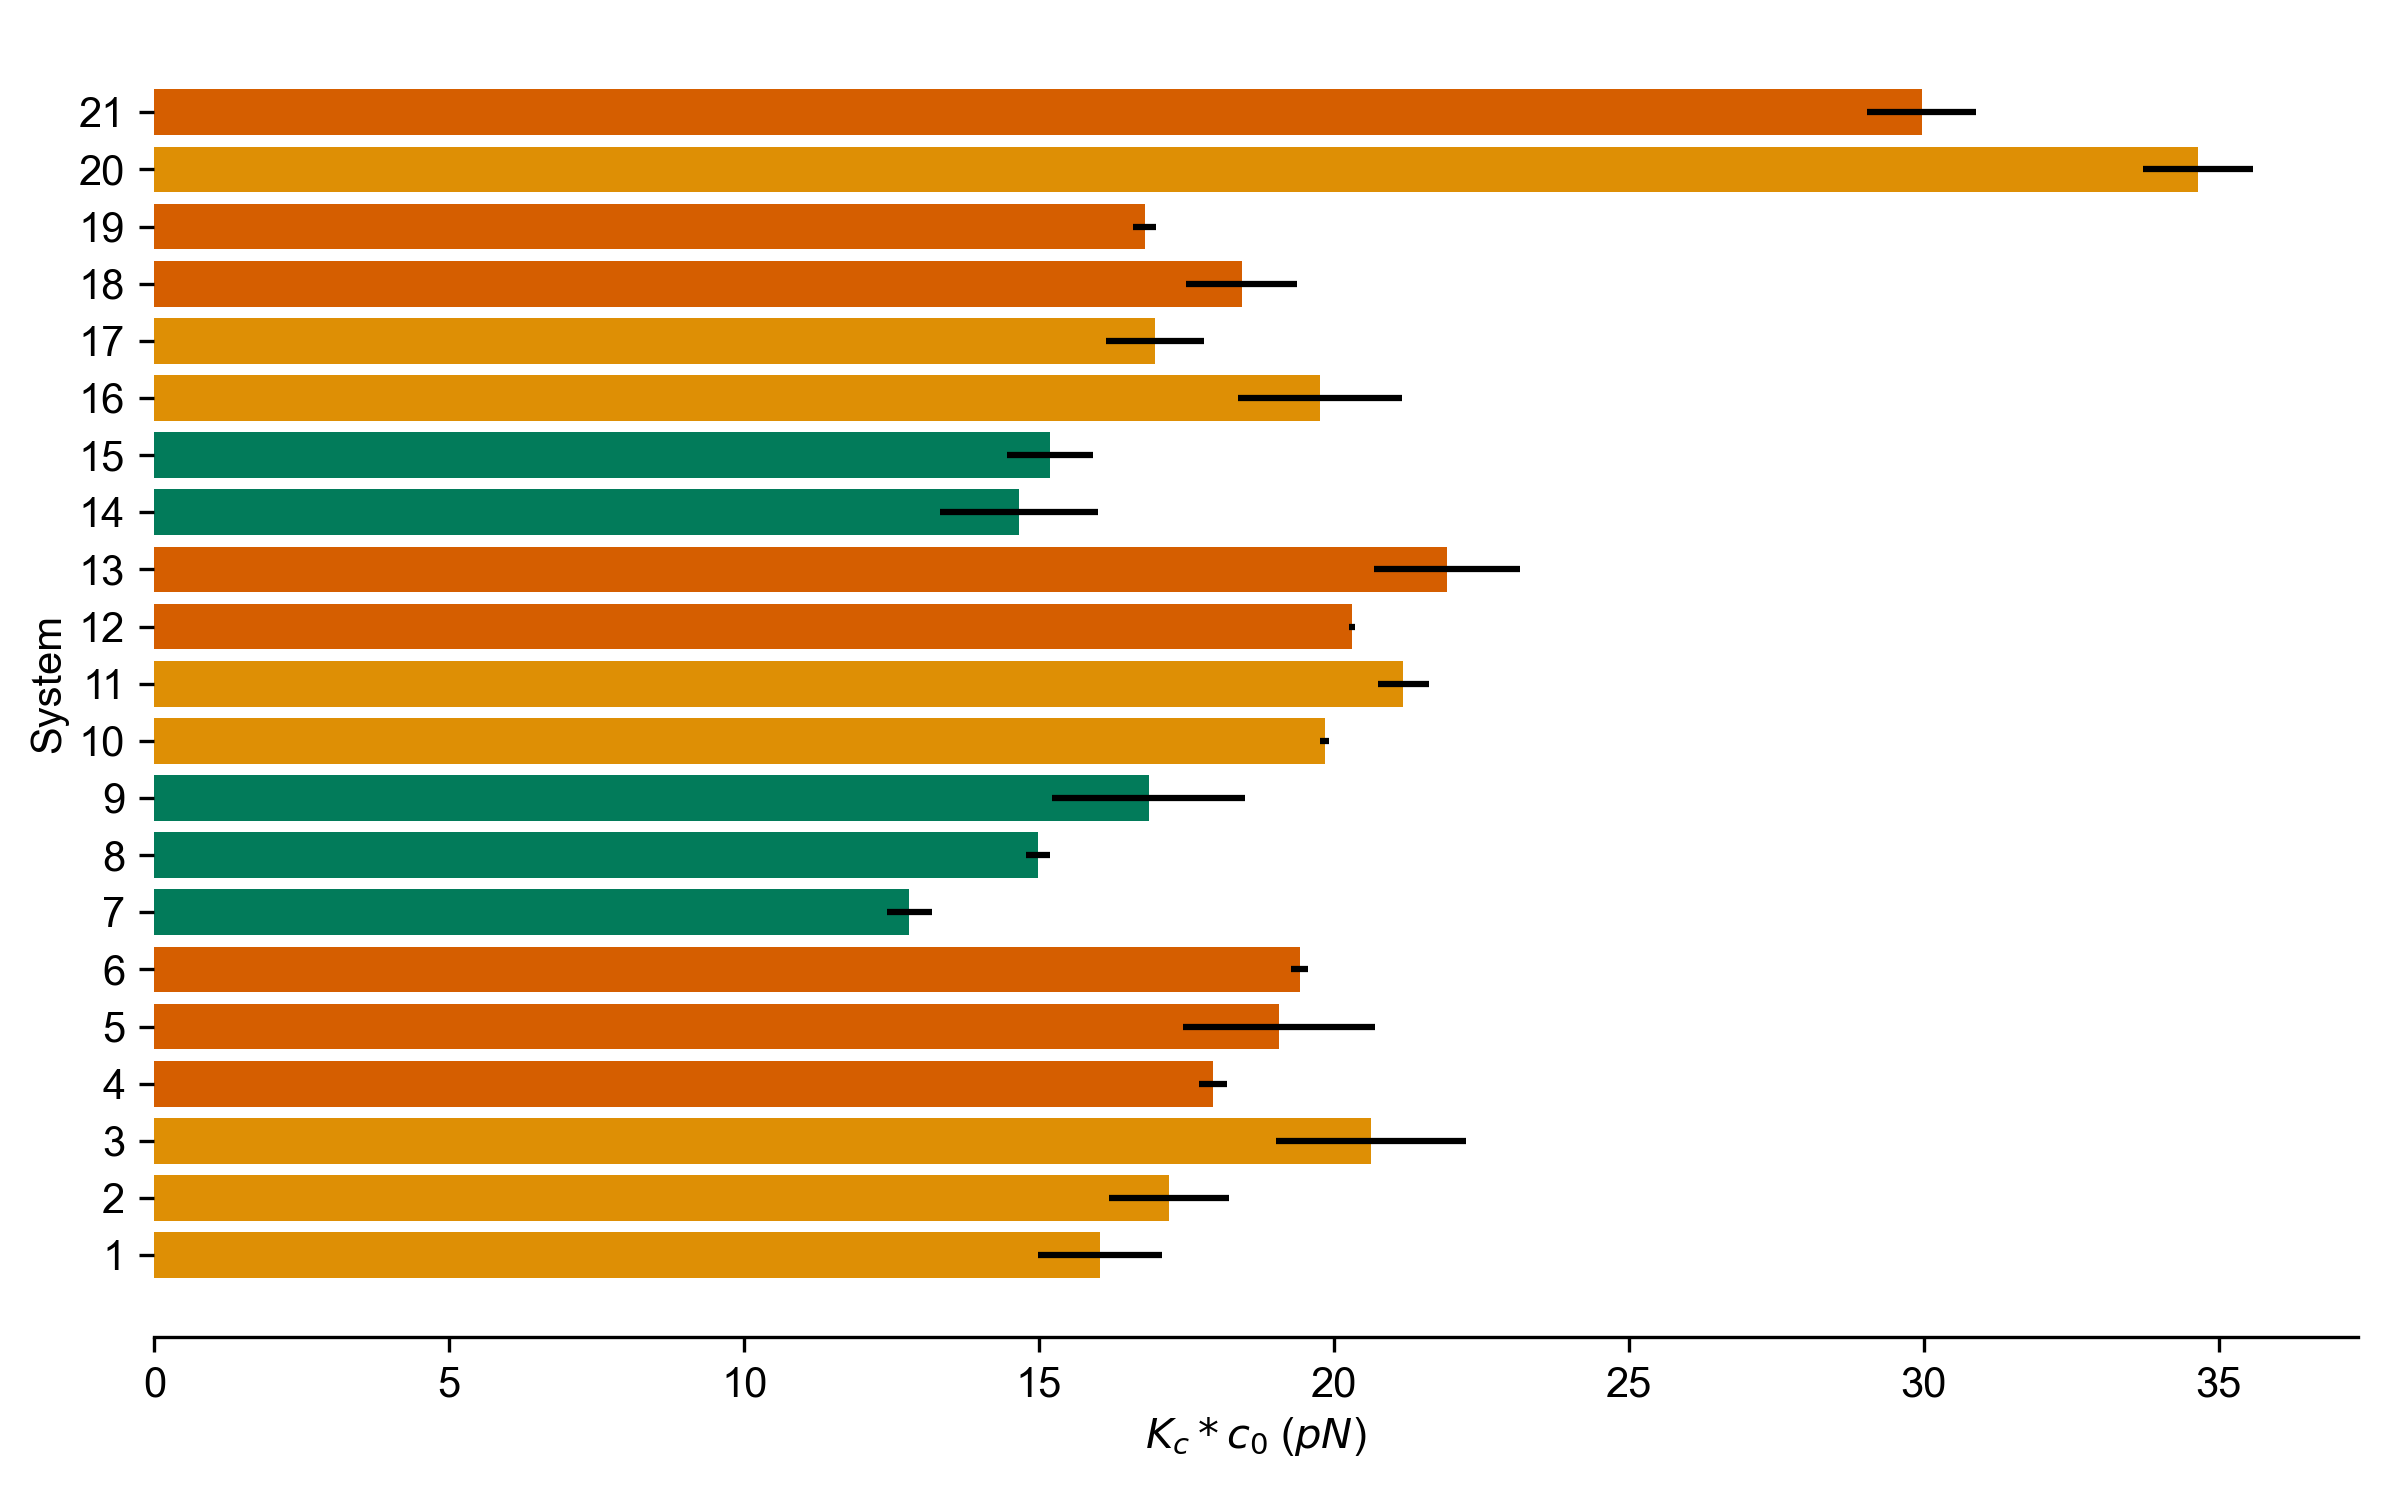

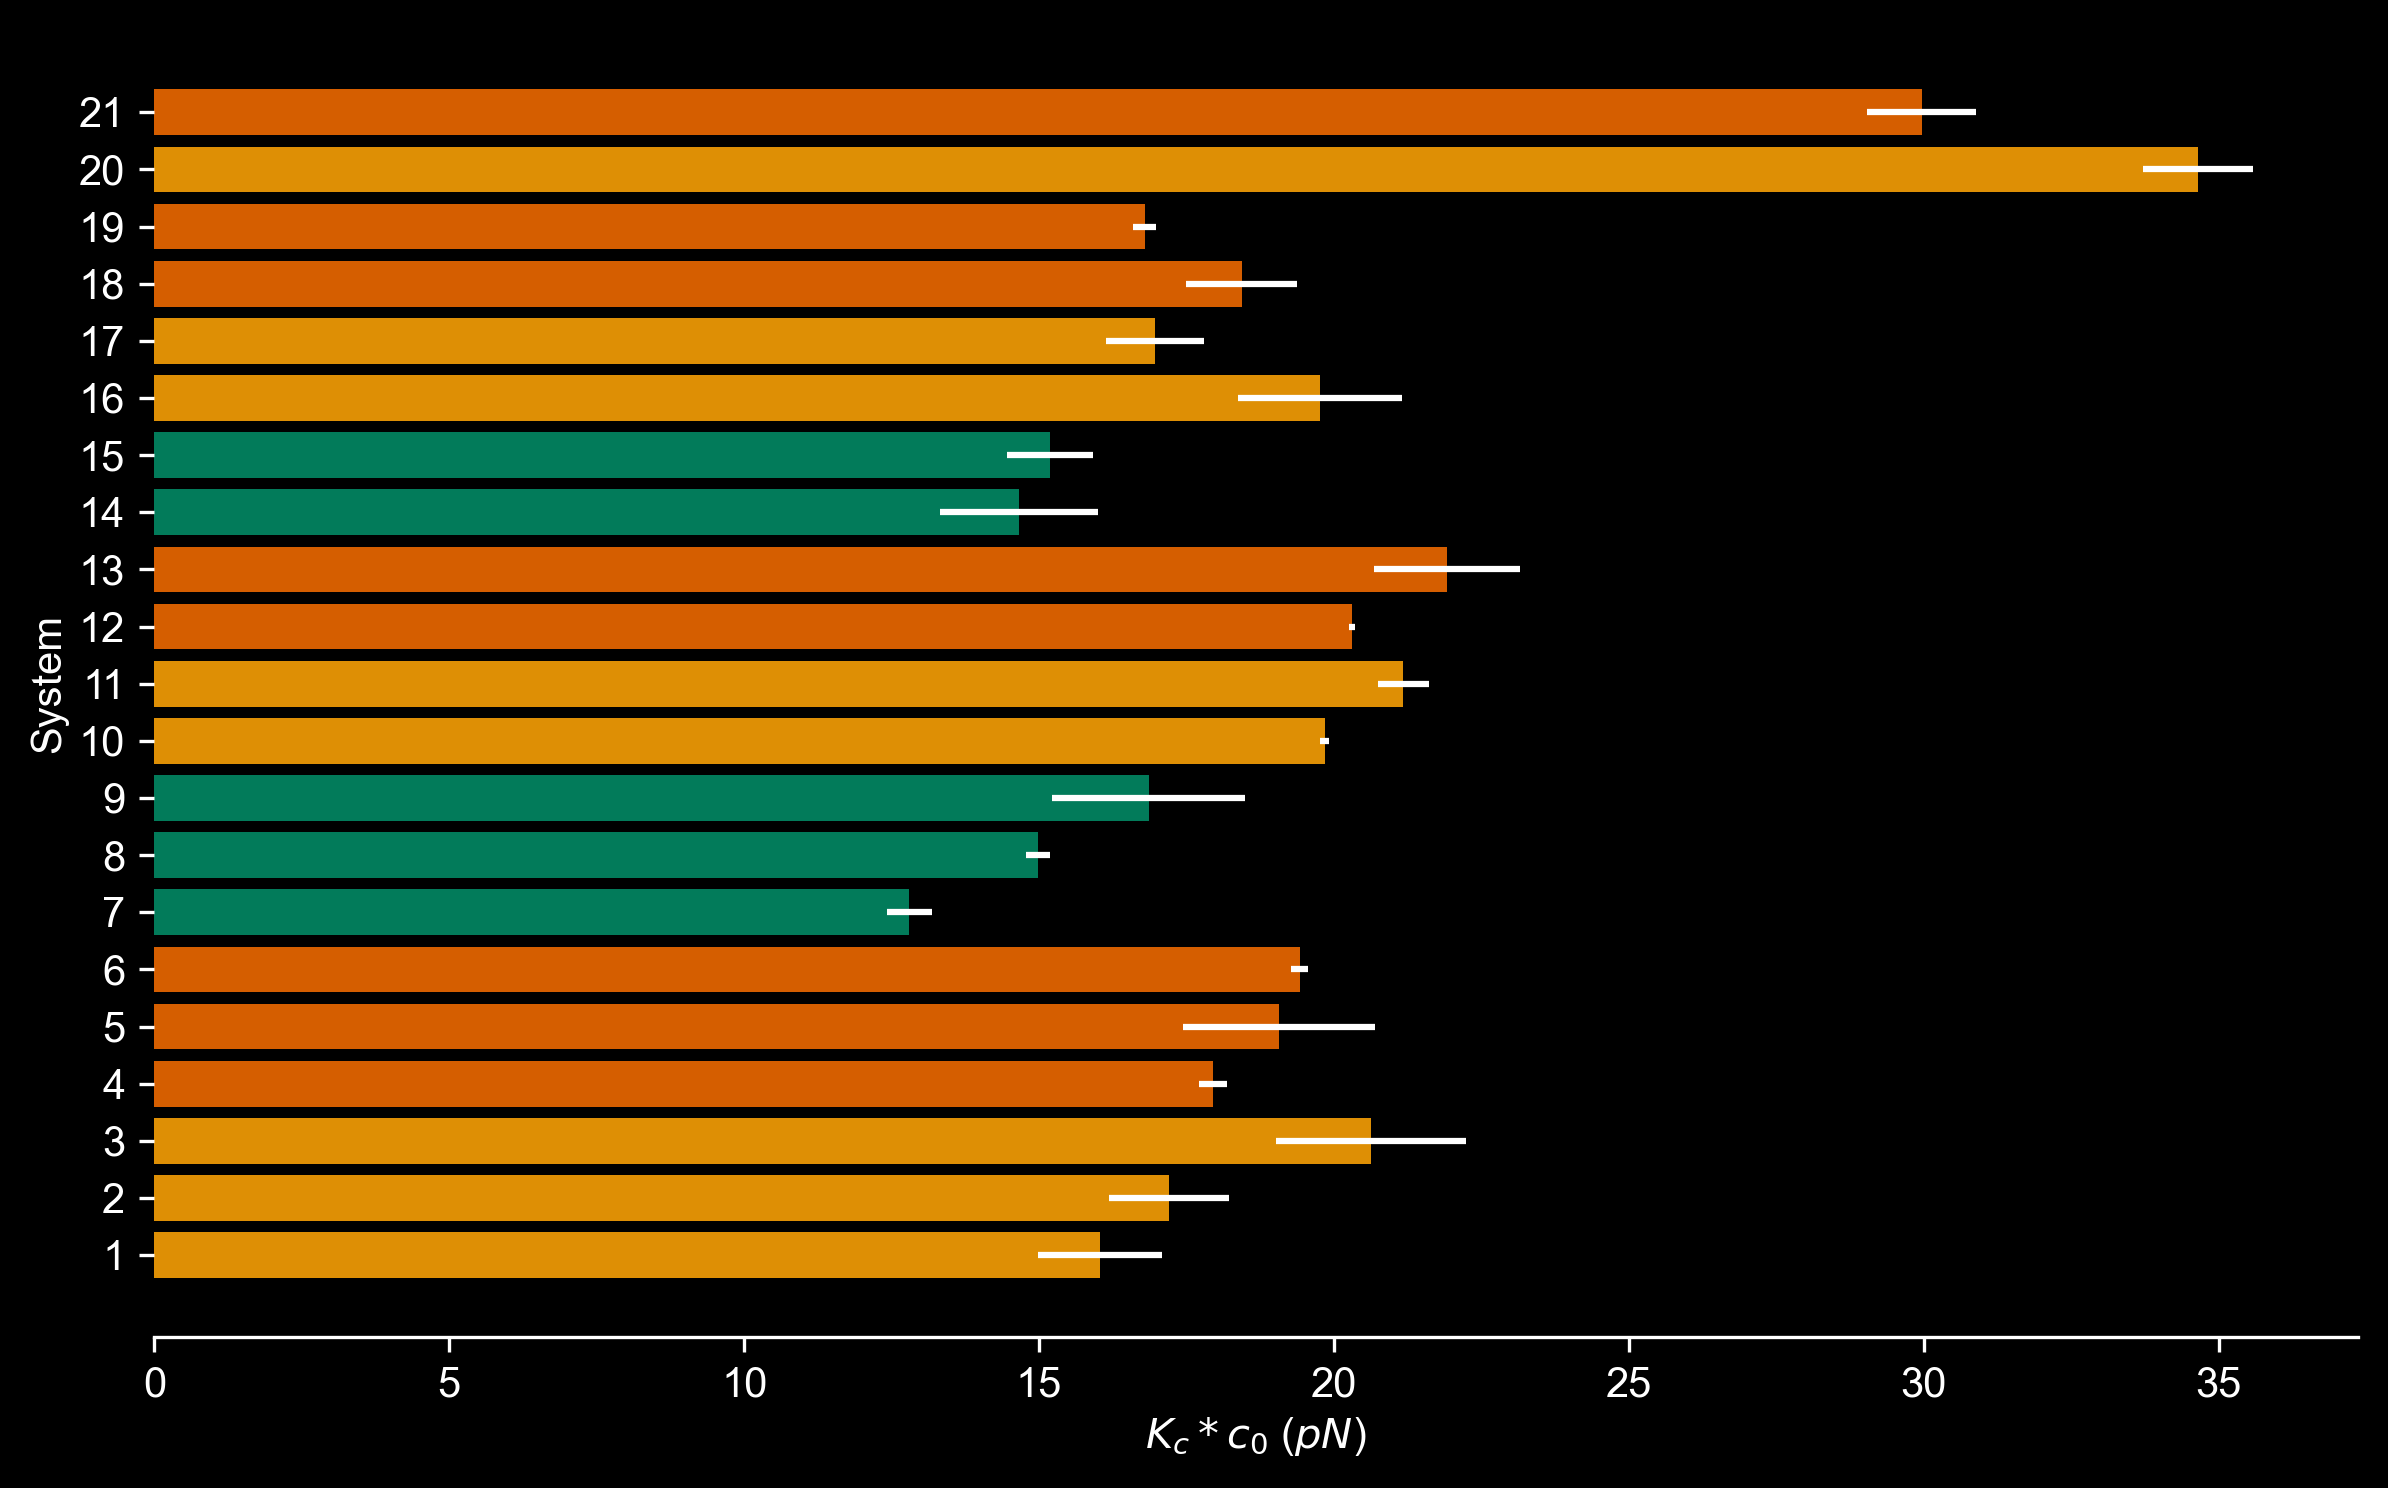

In [10]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"

        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(4, 7):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(7, 10):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(10, 12):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(12, 14):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(14, 16):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(16, 18):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(18, 20):
            ax.barh(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                xerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        ax.barh(
            "20",
            f_cubic_dat[util.remapping_dict[20]][0],
            xerr=f_cubic_dat[util.remapping_dict[20]][1],
            color=pal[1],
            ecolor=ecolor,
            height=0.8,
        )

        ax.barh(
            "21",
            f_cubic_dat[util.remapping_dict[21]][0],
            xerr=f_cubic_dat[util.remapping_dict[21]][1],
            color=pal[3],
            ecolor=ecolor,
            height=0.8,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_xlabel(r"$K_c*c_0$ ($pN$)")
        ax.set_ylabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"first_moment_all{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


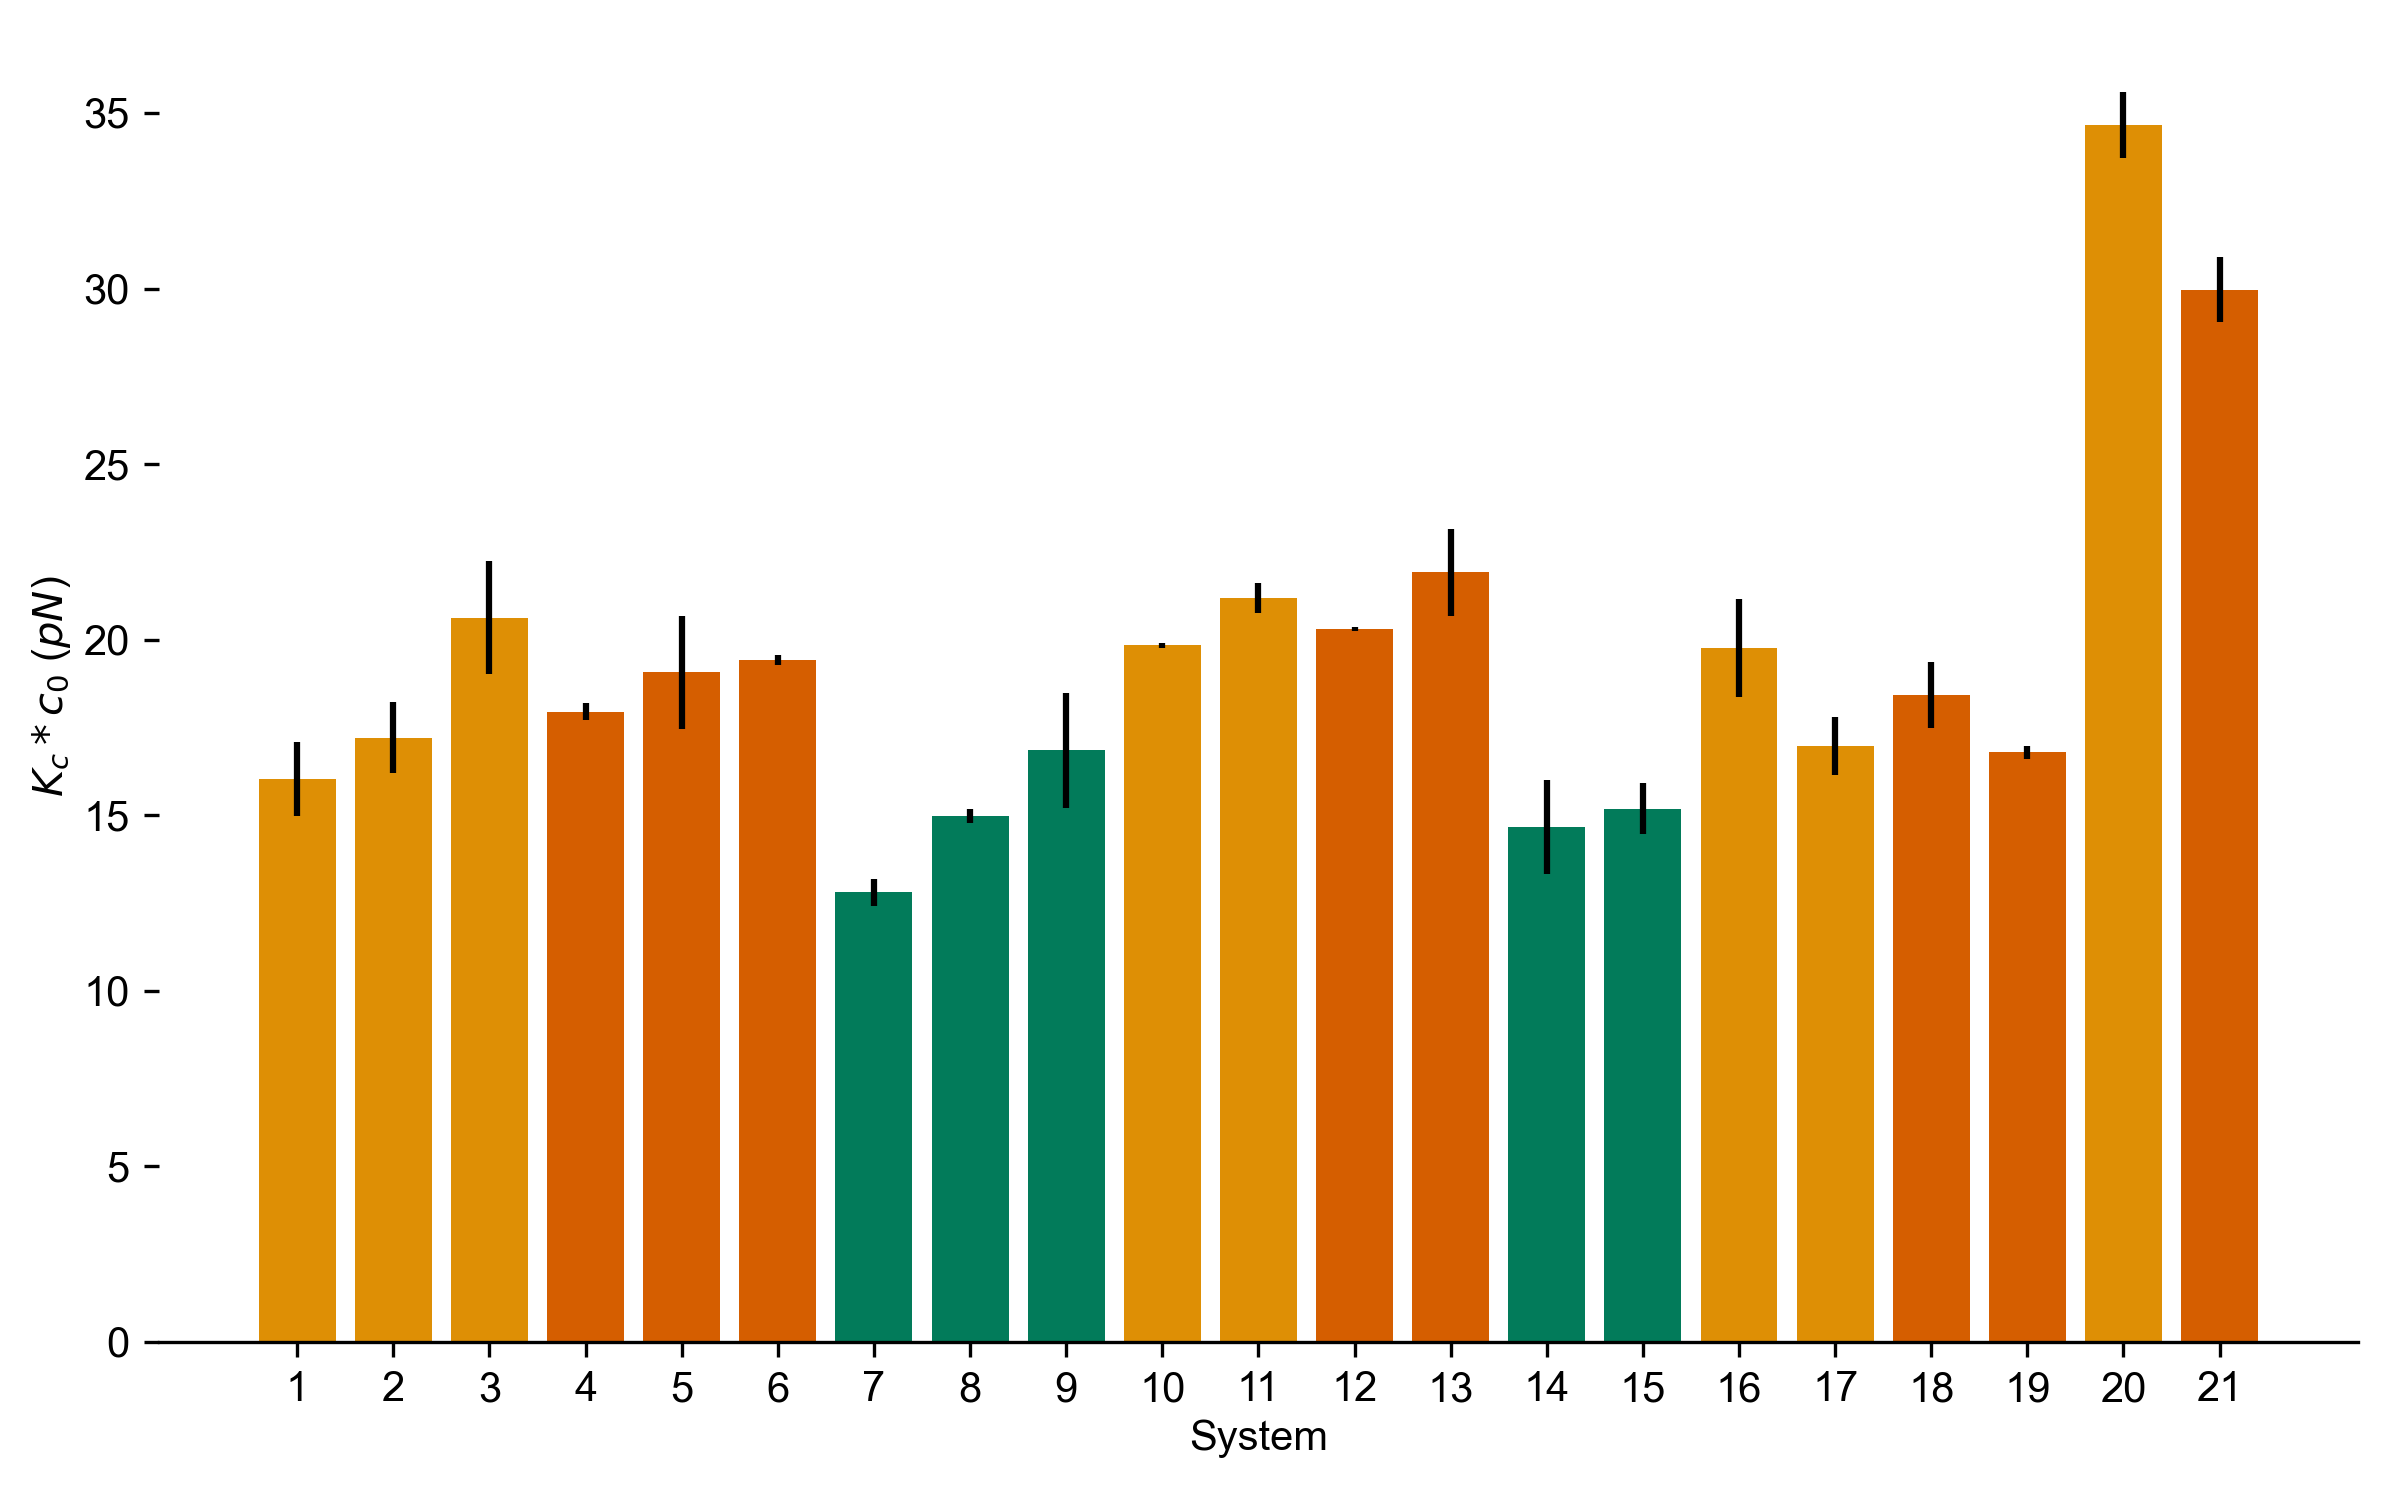

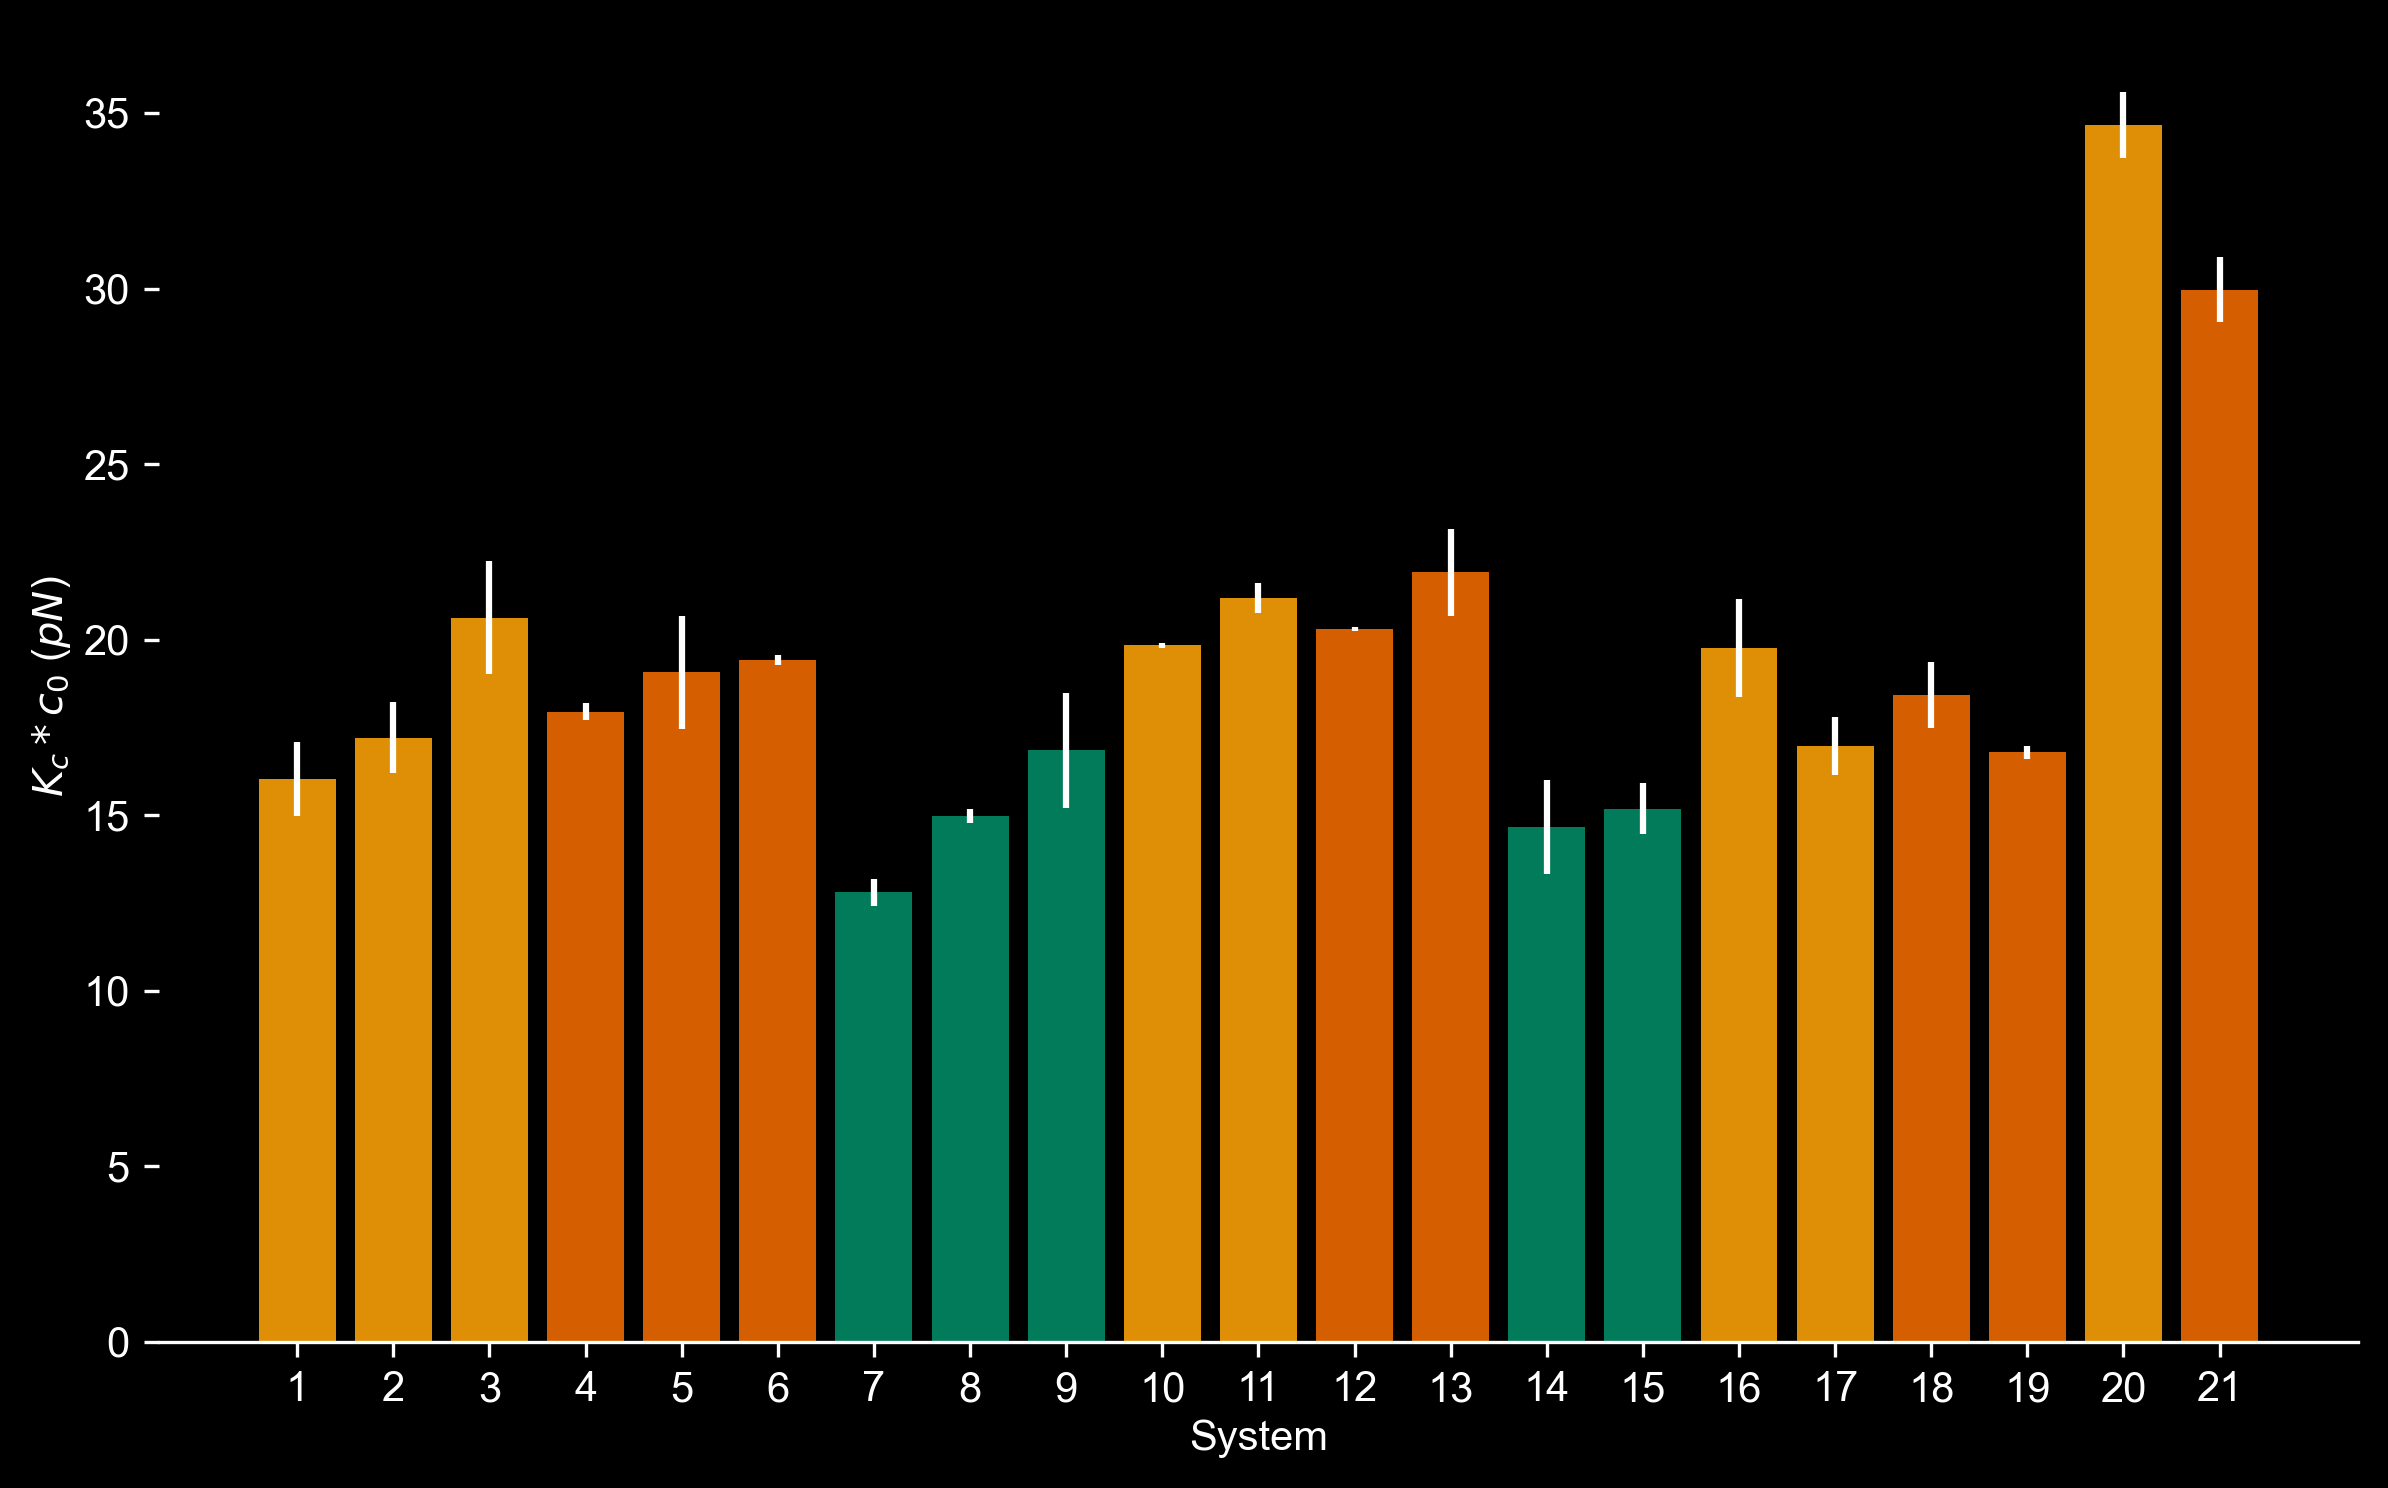

In [11]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"

        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(10, 12):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(16, 18):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            f_cubic_dat[util.remapping_dict[20]][0],
            yerr=f_cubic_dat[util.remapping_dict[20]][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            f_cubic_dat[util.remapping_dict[21]][0],
            yerr=f_cubic_dat[util.remapping_dict[21]][1],
            color=pal[3],
            ecolor=ecolor,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"$K_c*c_0$ ($pN$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"first_moment_all_vert{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


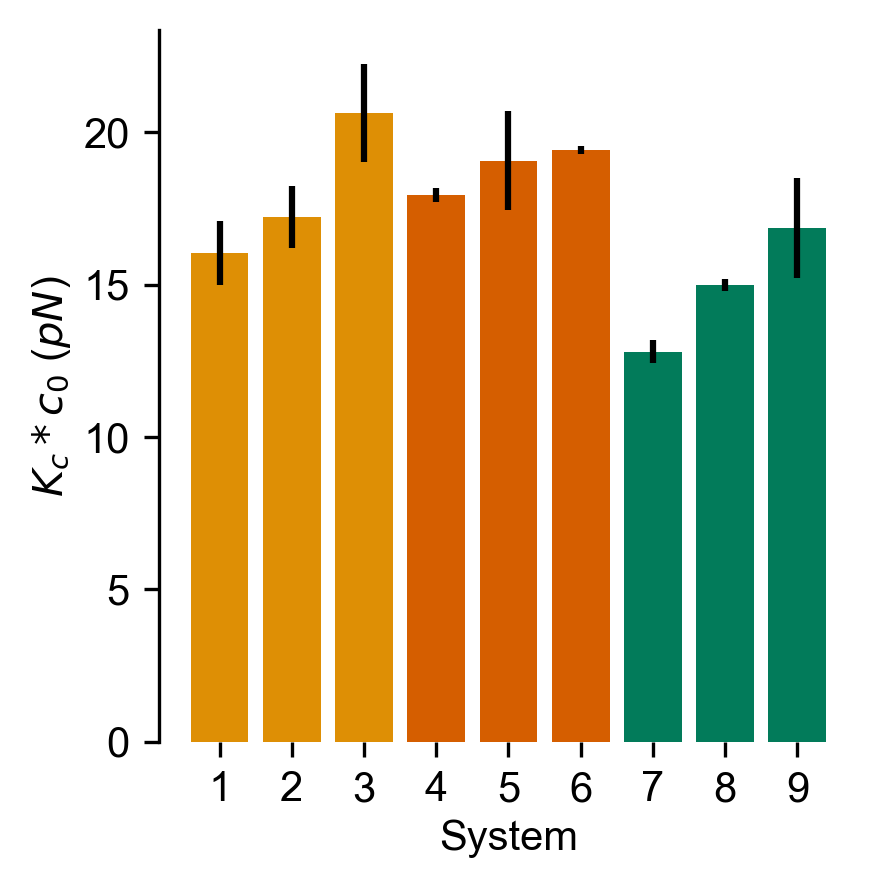

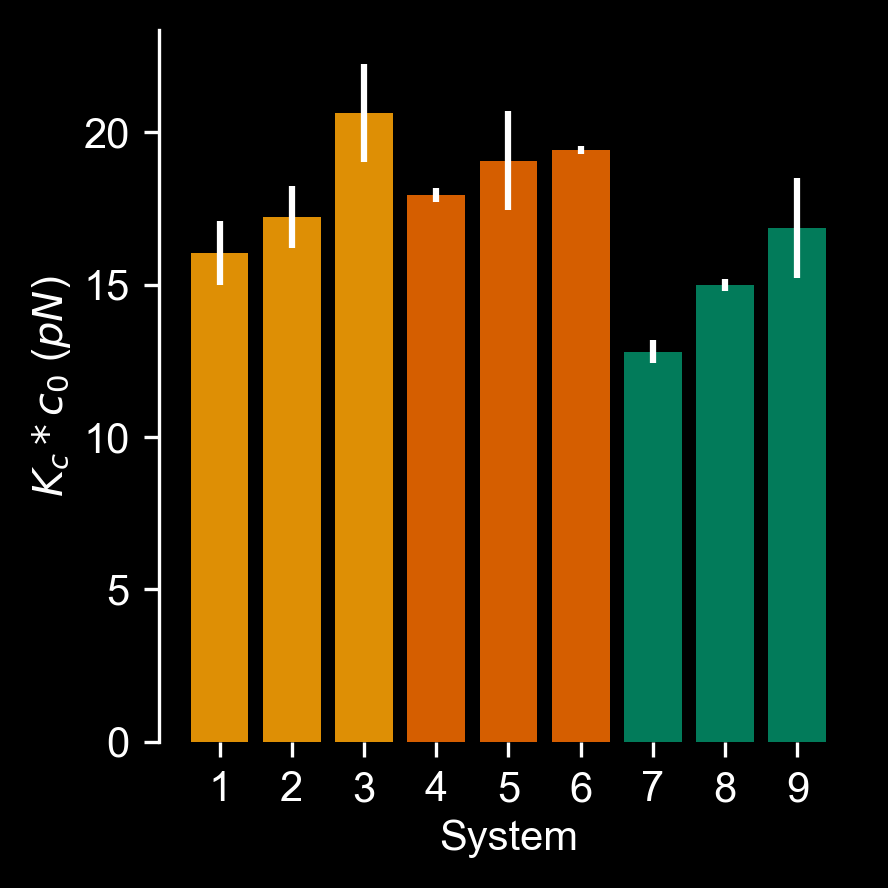

In [12]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)

for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(1, 4):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        ax.set_ylabel(r"$K_c*c_0$ ($pN$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"first_moment_1-9{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


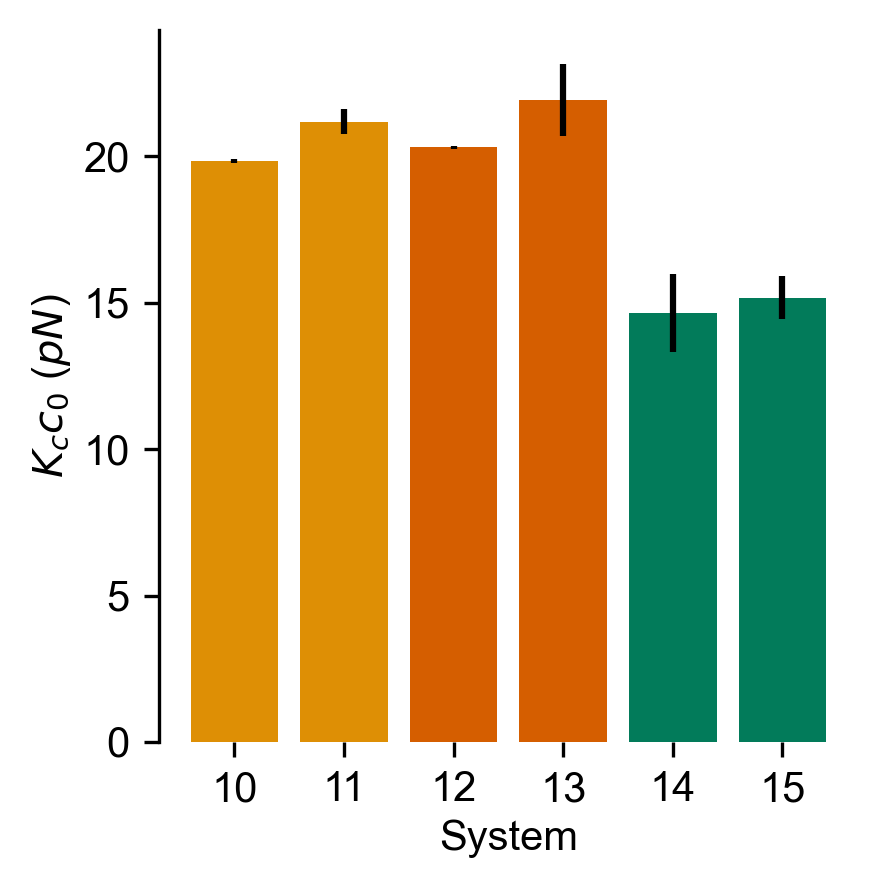

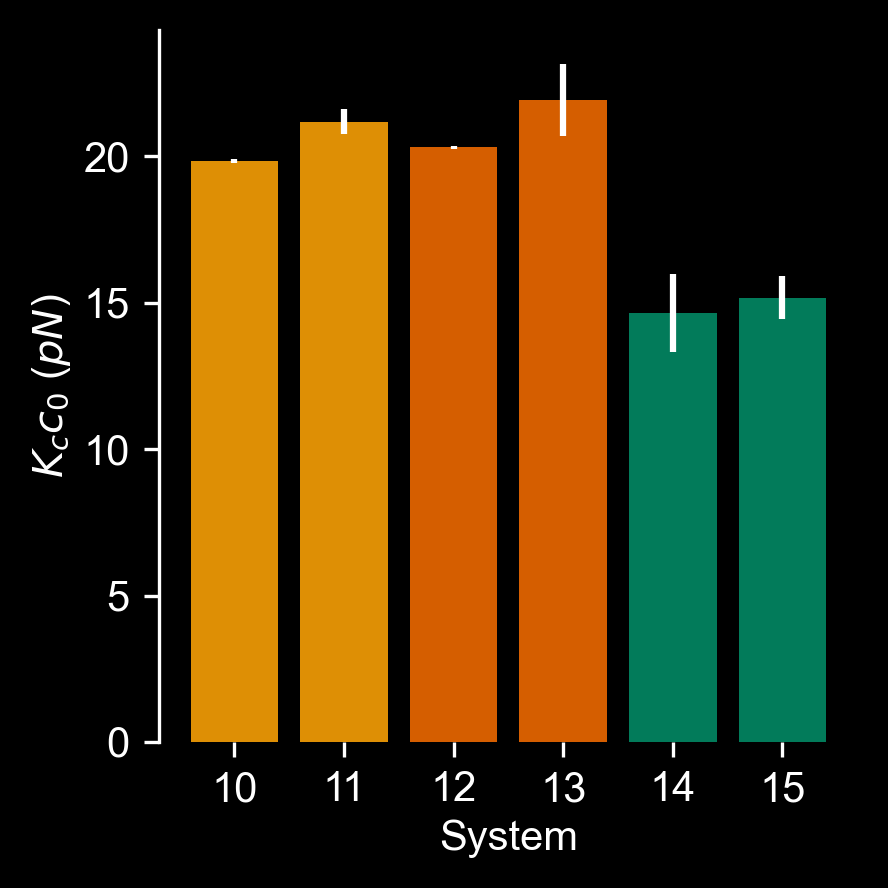

In [13]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(10, 12):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        ax.set_ylabel(r"$K_cc_0$ ($pN$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig,curr_fig_path / f"first_moment_10-15{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


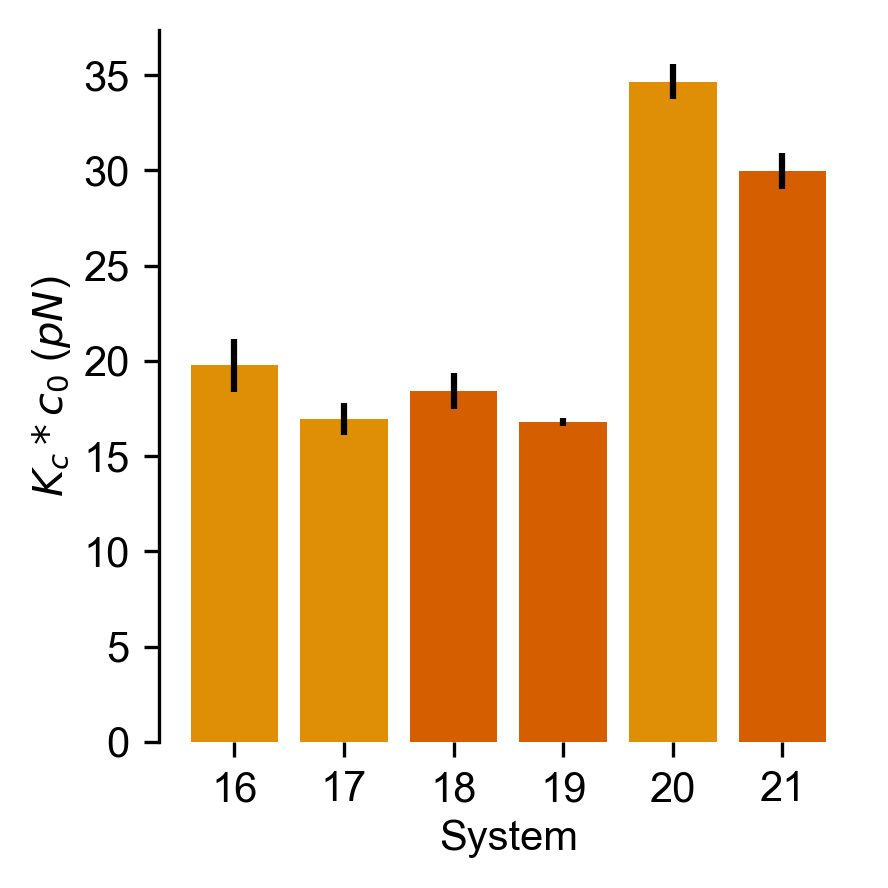

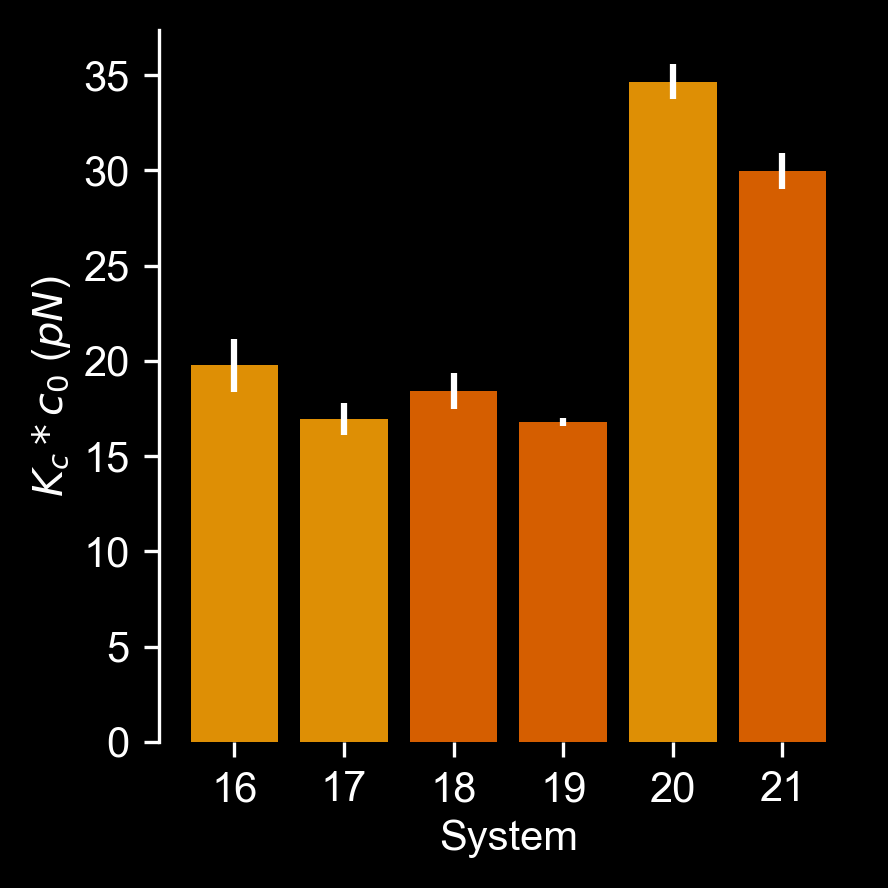

In [14]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(16, 18):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                f_cubic_dat[util.remapping_dict[i]][0],
                yerr=f_cubic_dat[util.remapping_dict[i]][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            f_cubic_dat[util.remapping_dict[20]][0],
            yerr=f_cubic_dat[util.remapping_dict[20]][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            f_cubic_dat[util.remapping_dict[21]][0],
            yerr=f_cubic_dat[util.remapping_dict[21]][1],
            color=pal[3],
            ecolor=ecolor,
        )

        ax.set_ylabel(r"$K_c*c_0$ ($pN$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0,40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"first_moment_16-21{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


In [15]:
for sim in range(1, 22):
    print(
        f"{sim}	{f_cubic_dat[util.remapping_dict[sim]][0]}	{f_cubic_dat[util.remapping_dict[sim]][1]}"
    )


1	16.03286282437595	1.0536865621641713
2	17.20805283906782	1.0175132614673912
3	20.629835253989757	1.607638384357882
4	17.947104297083634	0.23535776490290755
5	19.06476717044786	1.6227410774853286
6	19.416600578312067	0.1434981442766038
7	12.803441878734608	0.38923418458540543
8	14.98270415952958	0.20302097290977134
9	16.85631471842346	1.6368070225401494
10	19.84129800631053	0.07615494354665889
11	21.178758520273263	0.42637541322155437
12	20.312239833515836	0.05191382041136485
13	21.92038363454614	1.2398760893969238
14	14.654925696753708	1.3392816737315514
15	15.180519240533705	0.727955718565714
16	19.76287249559921	1.3931045151921833
17	16.96357984030202	0.8305041742152982
18	18.43516182652797	0.9423628440691832
19	16.791800380990967	0.1916277510501
20	34.65354304080213	0.929306198632866
21	29.962666832461675	0.9233429929144388


In [16]:
kc_mean_std = np.load("kc_mean_std.npy", allow_pickle=True).item()
print(kc_mean_std)
for sim in range(1, 22):
    remapped = util.remapping_dict[sim]
    print(sim, kc_mean_std[remapped])


{1: [7.518635663879712, 0.28700089753564867], 2: [7.522952733844585, 0.24569027914564287], 3: [8.899505257638213, 0.38588372103032503], 4: [16.235210943756233, 0.2542837839566556], 5: [16.098761802981, 0.2942701417300179], 6: [16.342300570941855, 0.28565909813525625], 7: [4.861000933751257, 0.14684335460547043], 8: [6.28009254912566, 0.2289783173225793], 9: [5.668780482578886, 0.2603803711139715], 10: [18.644686848778015, 0.2578054452441868], 11: [15.118052529687164, 0.20907242598454356], 12: [15.779157654523118, 0.23933822379376515], 13: [6.885615652155114, 0.32473493696291217], 14: [10.064032492792265, 0.2728175538191452], 15: [8.496766134292521, 0.2857300521779575], 16: [10.361760263397835, 0.2769151988373418], 17: [10.864030250872831, 0.2974783611855152], 18: [11.947171663647728, 0.2944560165427397], 19: [11.550992685817052, 0.2366106154774084], 20: [12.550411099188745, 0.30658204947101275], 21: [10.310540076844749, 0.3242008343981848], 22: [8.787368559374793, 0.3250205248824384], 

In [17]:
c0 = {}
one_over_c0 = {}
for sim in range(1, 22):
    remapped = util.remapping_dict[sim]
    value = f_cubic_dat[remapped][0] / (kc_mean_std[remapped][0] * 4.18336647)
    error = (
        np.sqrt(
            (f_cubic_dat[remapped][1] / f_cubic_dat[remapped][0]) ** 2
            + (kc_mean_std[remapped][1] / kc_mean_std[remapped][0]) ** 2
        )
        * value
    )

    c0[sim] = (value, error)

    one_over_c0[sim] = (1 / value, error / value / value)

    print(
        f"System {sim} c0: {value: 0.3f} +/- {error:0.3f} nm^-1; {1 / value} +/- {error/value/value} nm"
    )


System 1 c0:  0.510 +/- 0.039 nm^-1; 1.9617961359090486 +/- 0.14910000618831076 nm
System 2 c0:  0.547 +/- 0.037 nm^-1; 1.8288686417042122 +/- 0.12353948510941914 nm
System 3 c0:  0.580 +/- 0.049 nm^-1; 1.7229942029108798 +/- 0.1462374121283548 nm
System 4 c0:  0.414 +/- 0.012 nm^-1; 2.4152665376286175 +/- 0.07189981678423898 nm
System 5 c0:  0.419 +/- 0.038 nm^-1; 2.38388538785913 +/- 0.2131508465555698 nm
System 6 c0:  0.407 +/- 0.012 nm^-1; 2.4550533052675254 +/- 0.06969235517105274 nm
System 7 c0:  0.189 +/- 0.006 nm^-1; 5.304654618559439 +/- 0.18140979318658856 nm
System 8 c0:  0.222 +/- 0.005 nm^-1; 4.494984324460024 +/- 0.10227802929321599 nm
System 9 c0:  0.255 +/- 0.025 nm^-1; 3.9160397844630213 +/- 0.38487233312487157 nm
System 10 c0:  0.837 +/- 0.039 nm^-1; 1.1952134476821275 +/- 0.05509029040551735 nm
System 11 c0:  0.806 +/- 0.034 nm^-1; 1.2404848269722912 +/- 0.05166599478920507 nm
System 12 c0:  0.471 +/- 0.015 nm^-1; 2.1234865282504747 +/- 0.06699033246640414 nm
System 

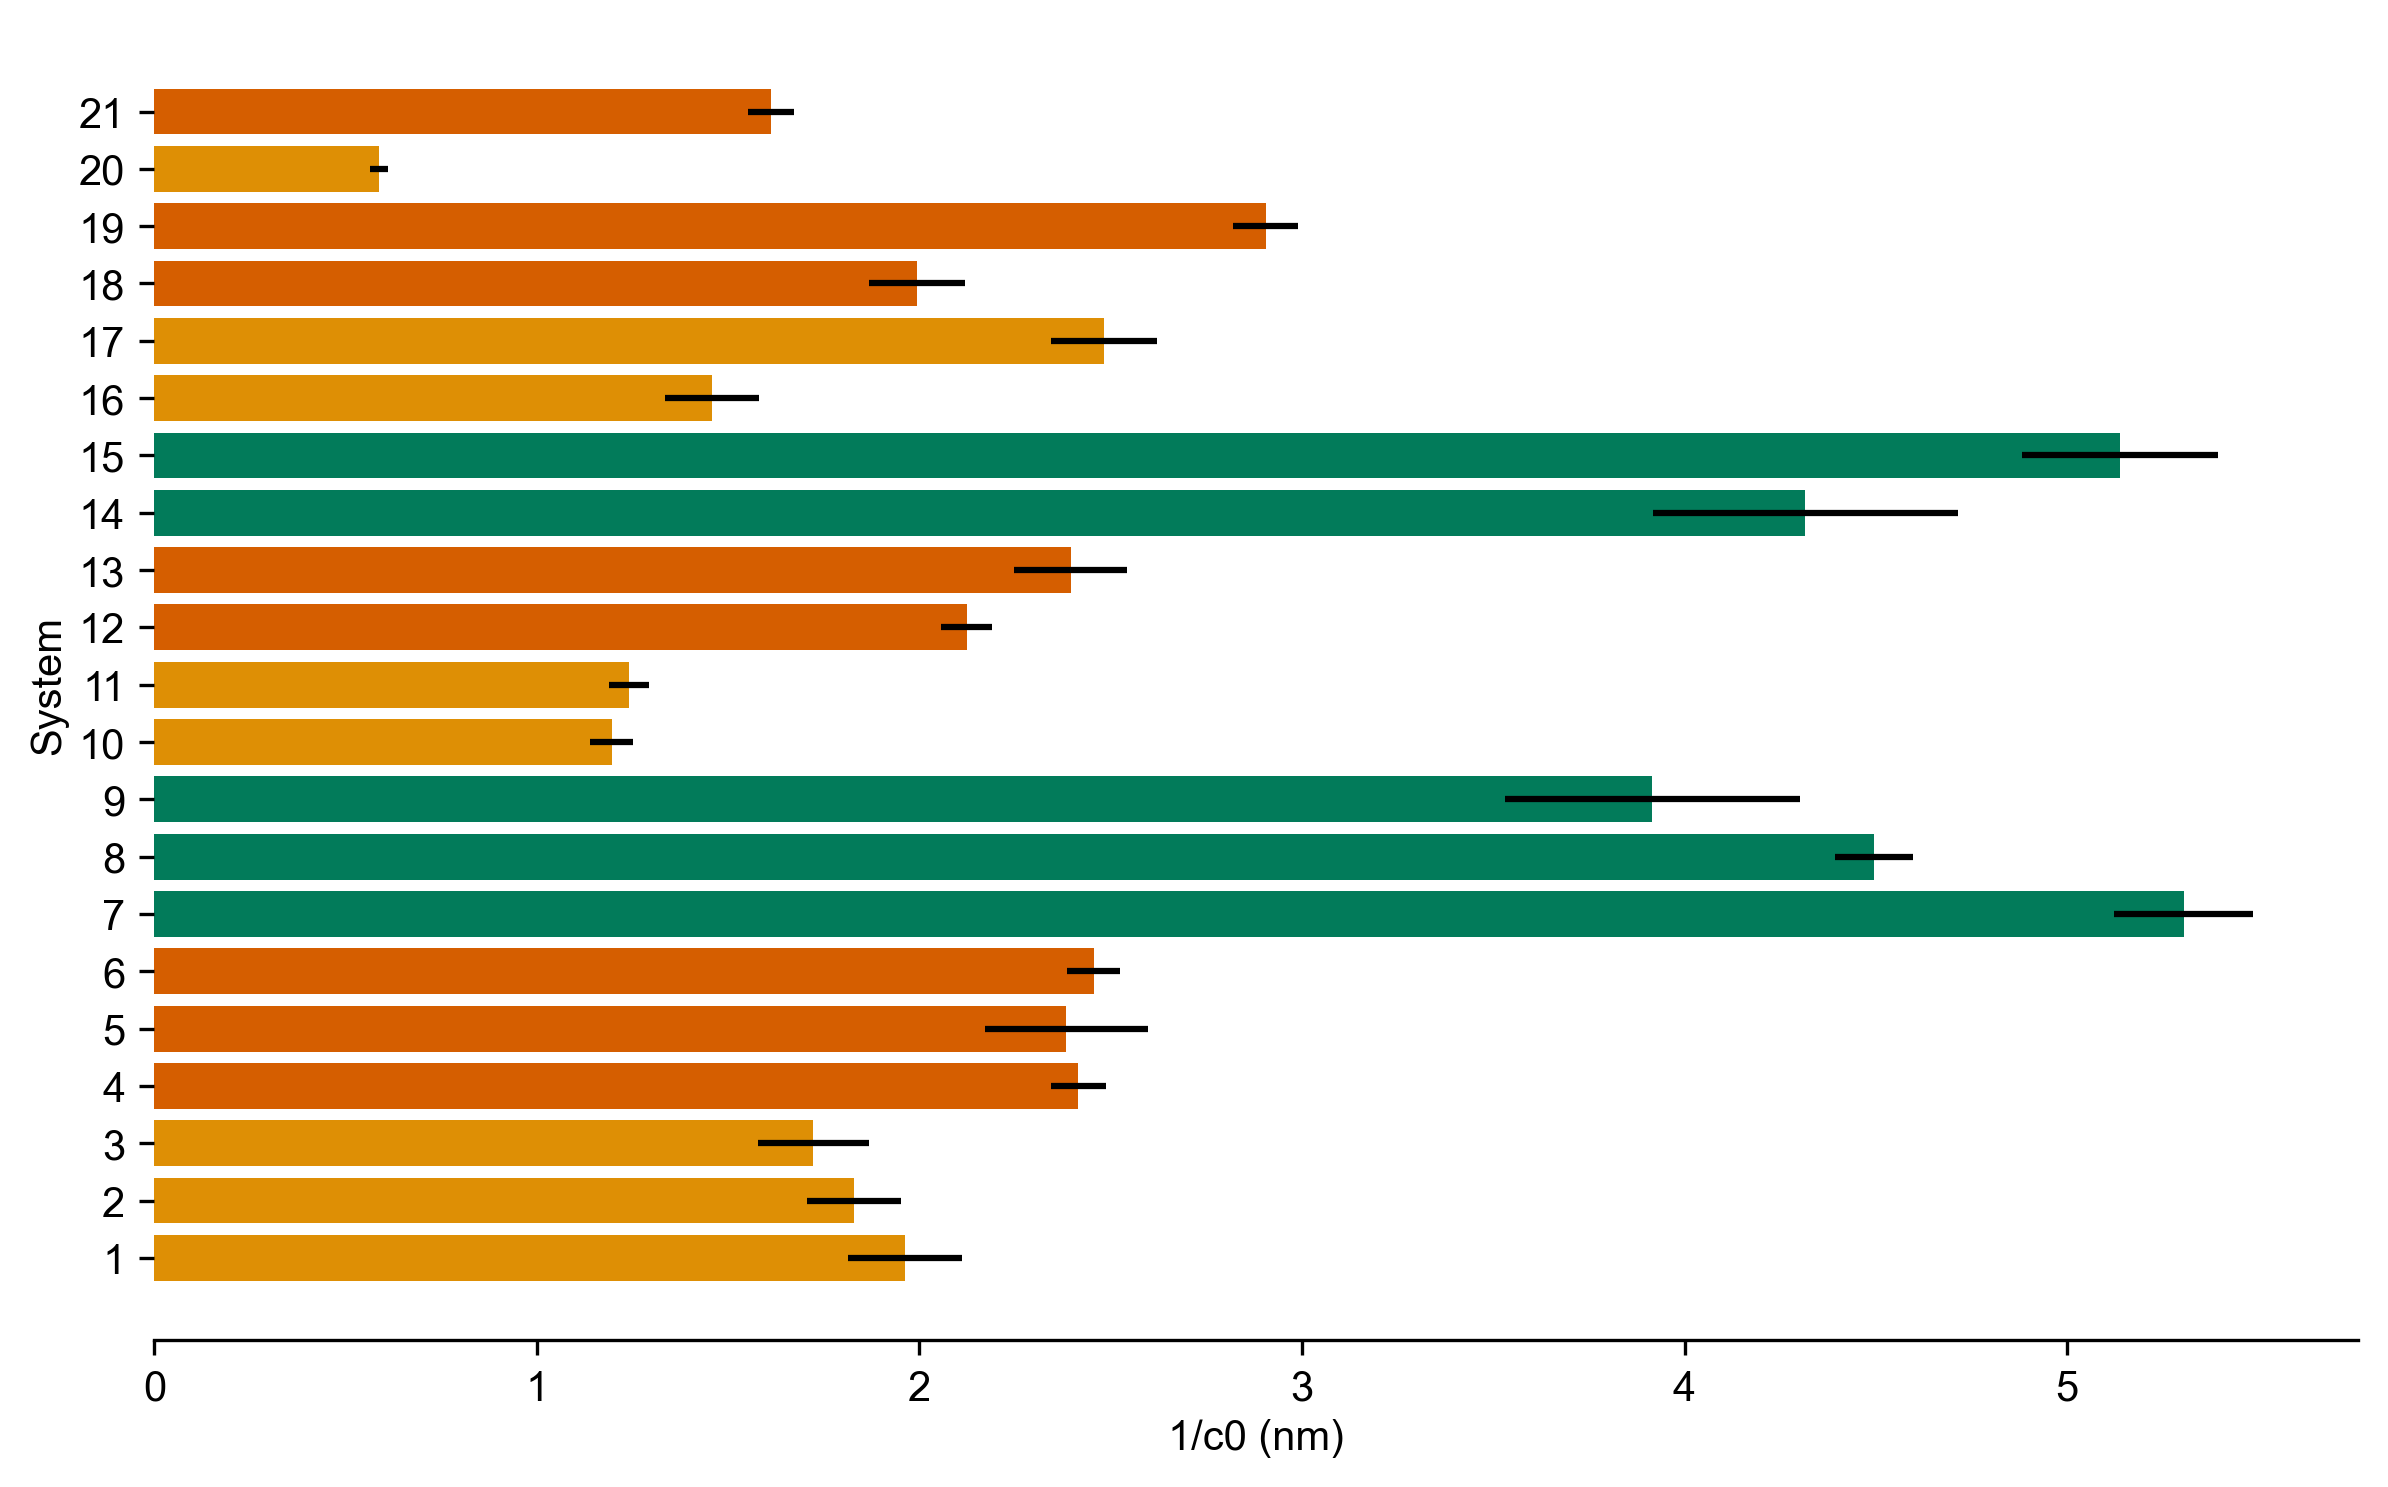

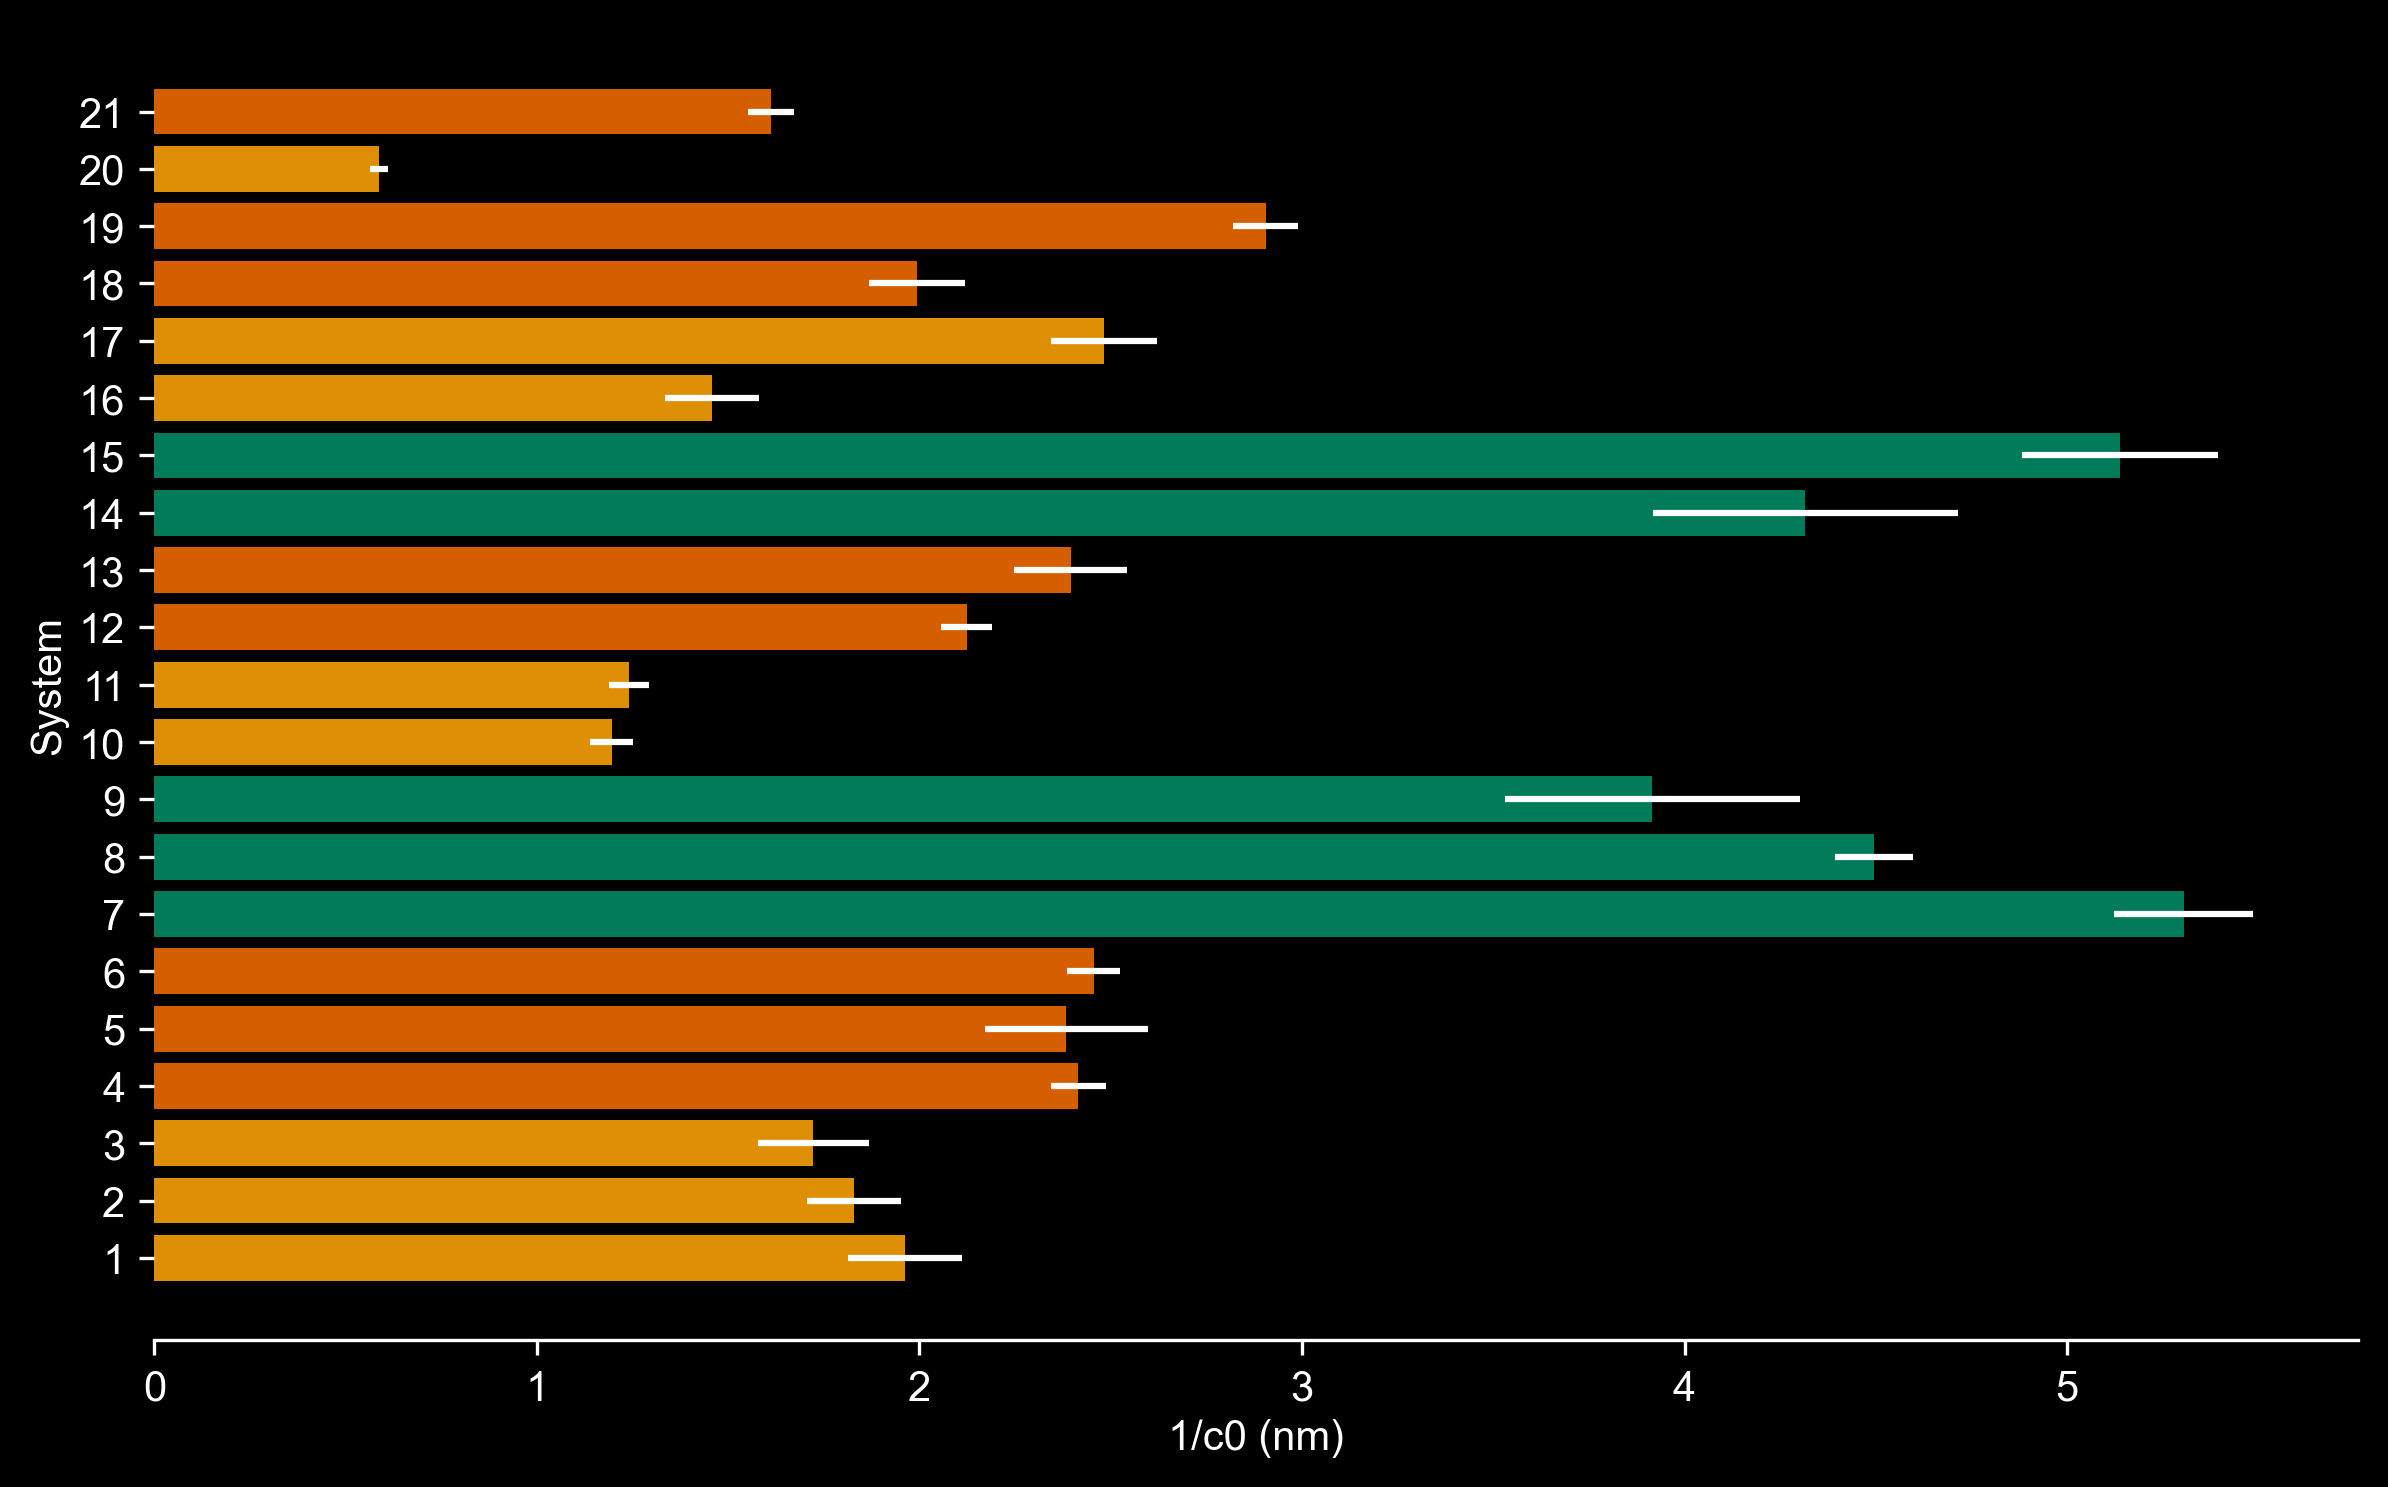

In [18]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(4, 7):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(7, 10):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(10, 12):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(12, 14):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(14, 16):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(16, 18):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[1],
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(18, 20):
            ax.barh(
                str(i),
                one_over_c0[i][0],
                xerr=one_over_c0[i][1],
                color=pal[3],
                ecolor=ecolor,
                height=0.8,
            )

        ax.barh(
            "20", one_over_c0[20][0], xerr=one_over_c0[20][1], color=pal[1], ecolor=ecolor,height=0.8
        )

        ax.barh(
            "21", one_over_c0[21][0], xerr=one_over_c0[21][1], color=pal[3], ecolor=ecolor,height=0.8
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_xlabel(r"1/c0 (nm)")
        ax.set_ylabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature{style_ext}")
        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


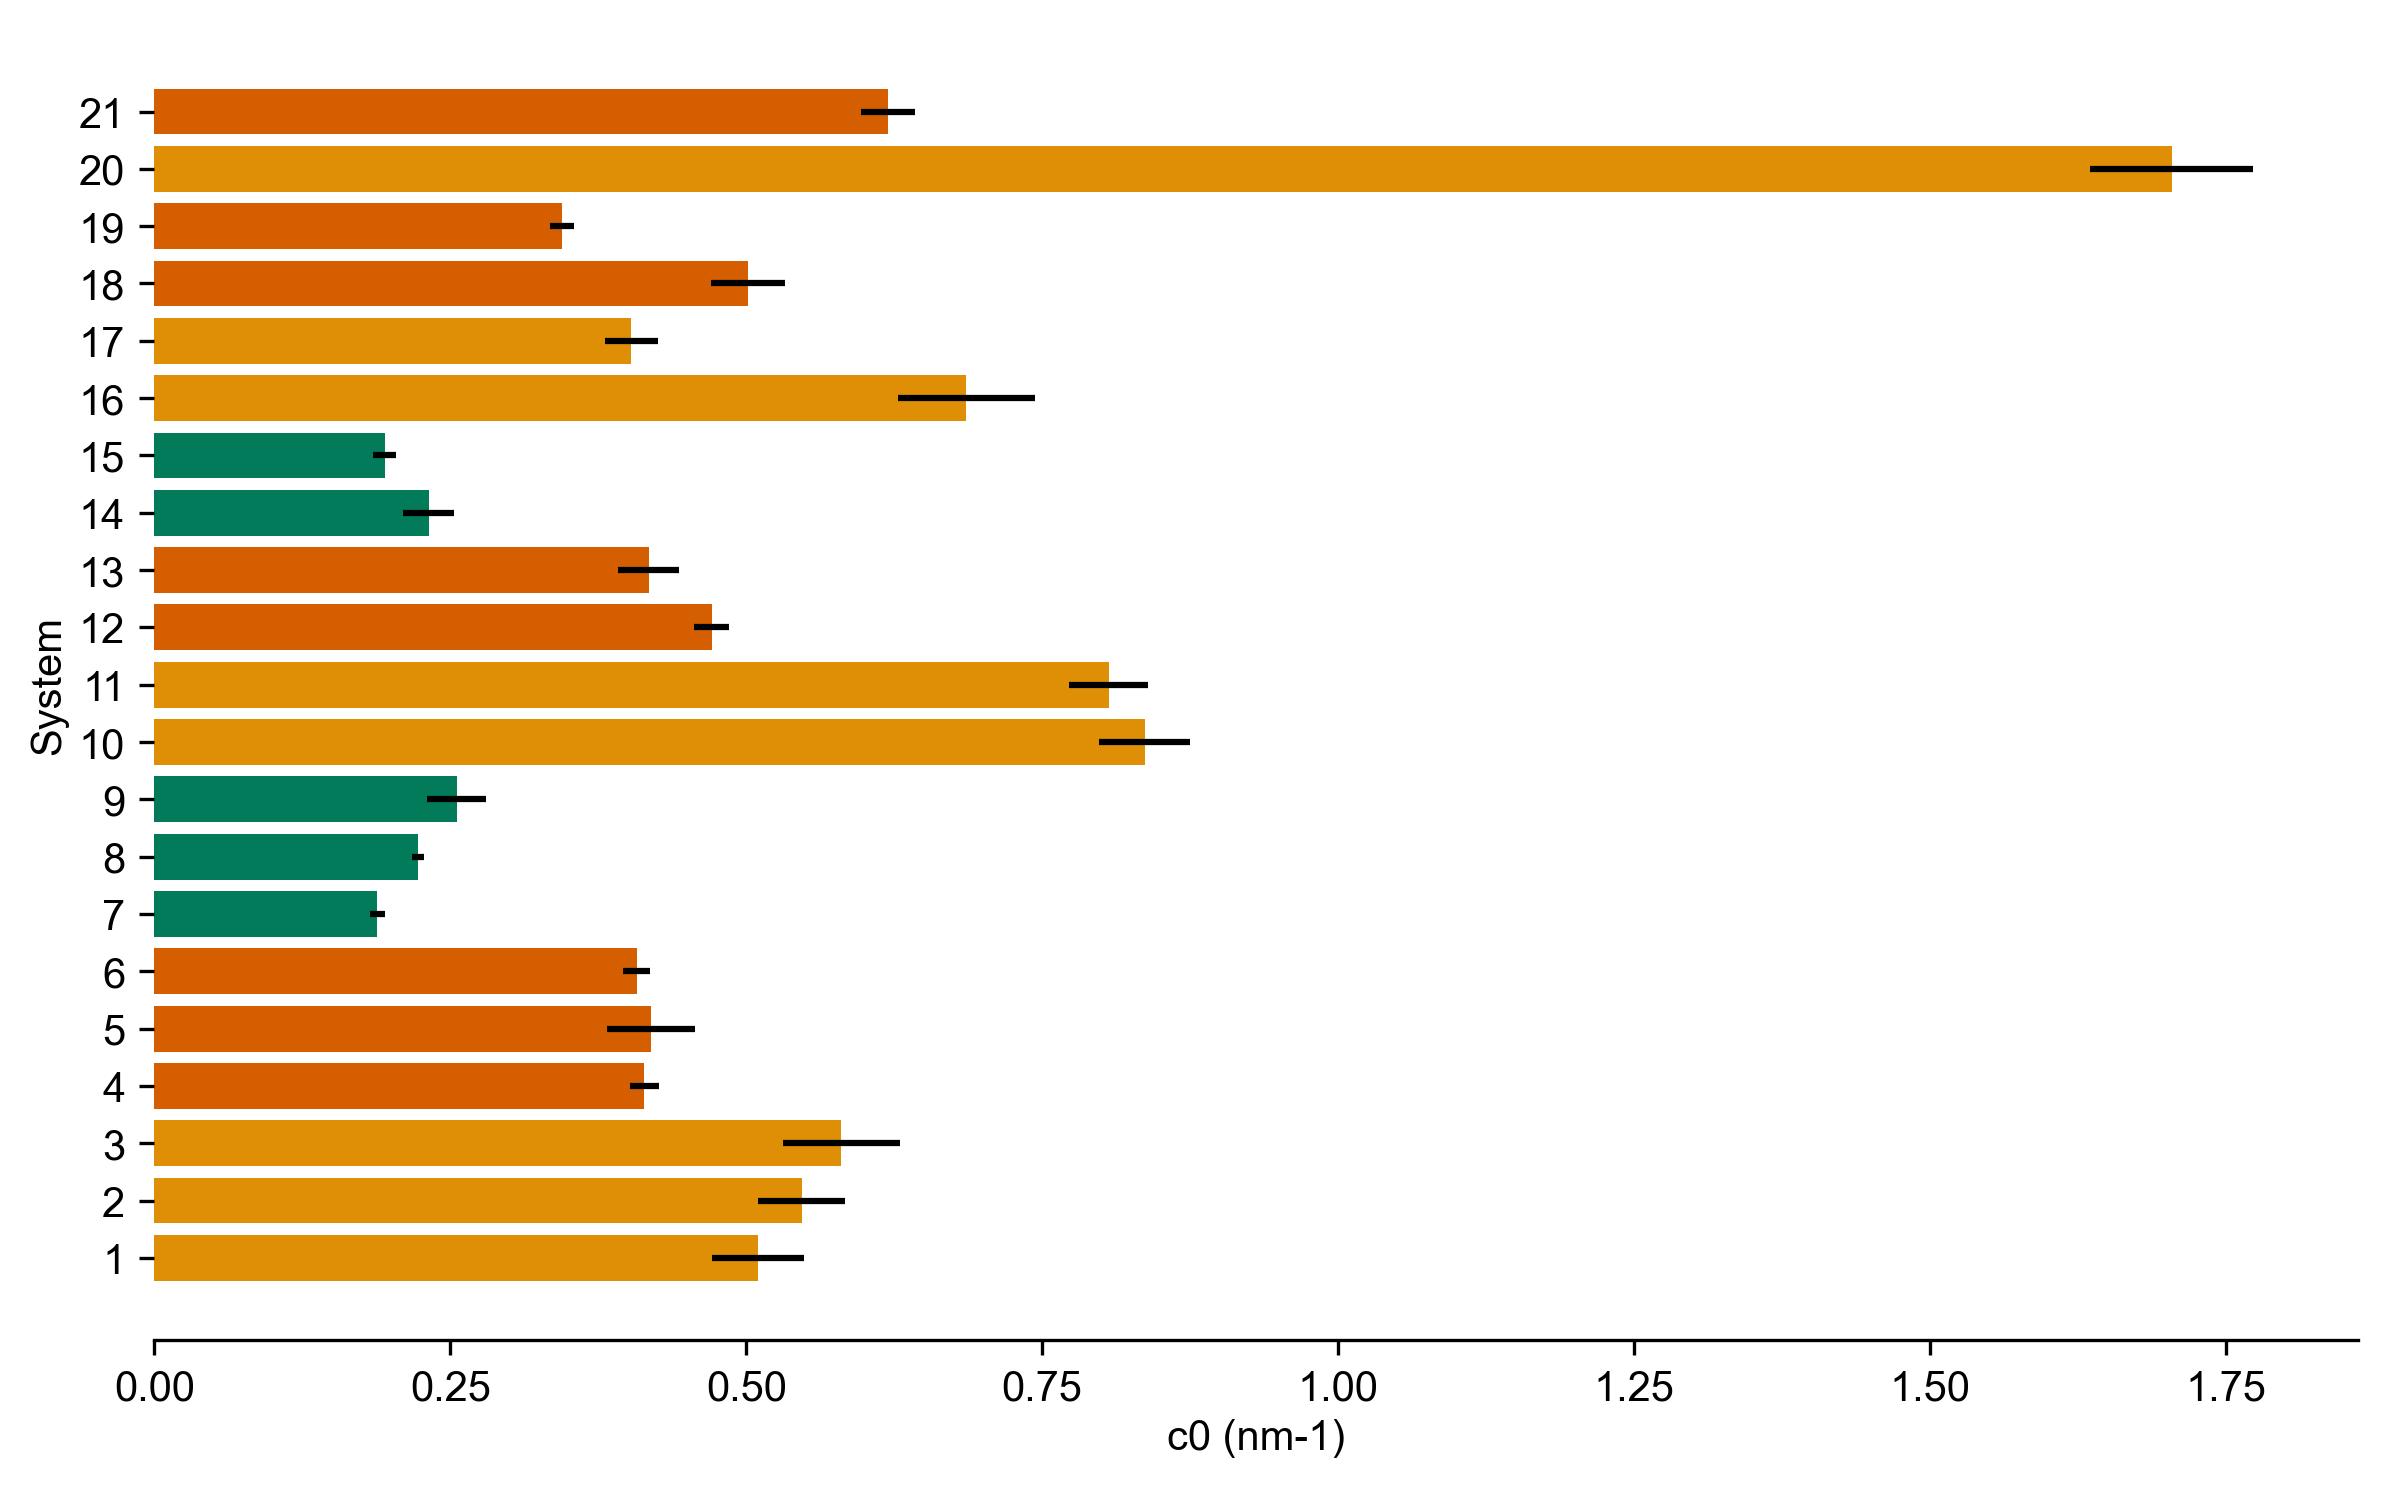

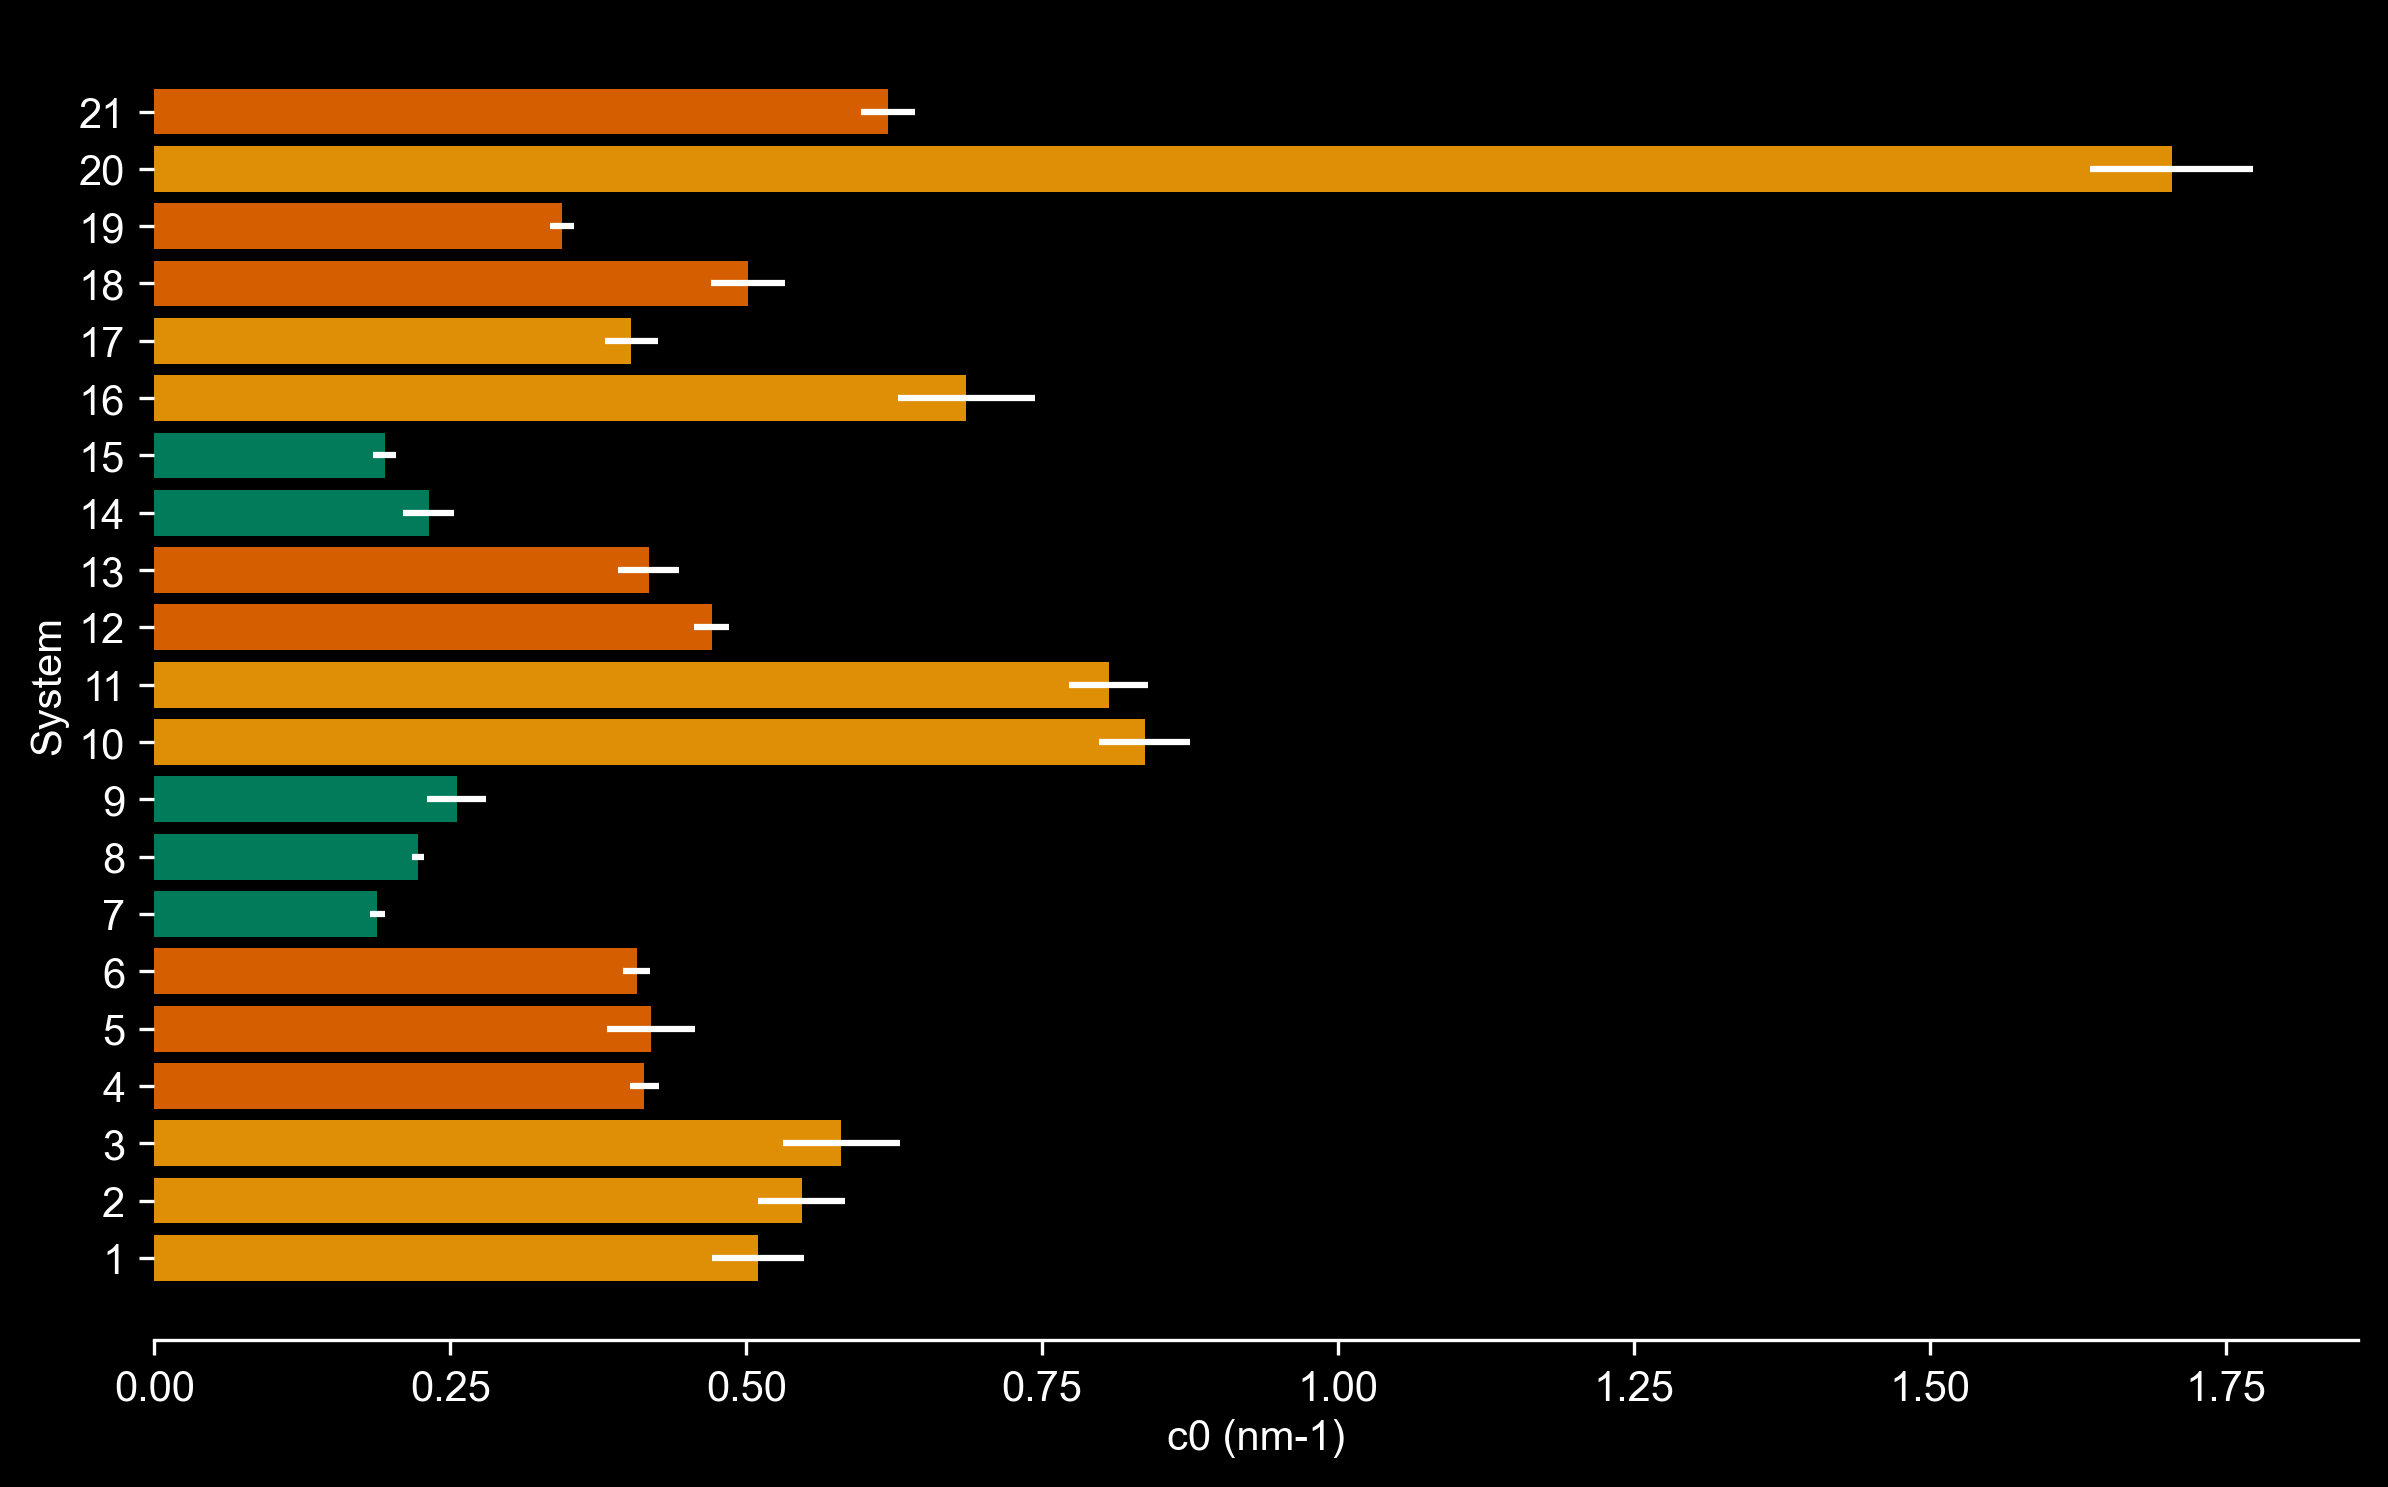

In [19]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[1], ecolor=ecolor, height=0.8
            )

        for i in range(4, 7):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[3], ecolor=ecolor, height=0.8
            )

        for i in range(7, 10):
            ax.barh(
                str(i),
                c0[i][0],
                xerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
                height=0.8,
            )

        for i in range(10, 12):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[1], ecolor=ecolor, height=0.8
            )

        for i in range(12, 14):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[3], ecolor=ecolor, height=0.8
            )

        for i in range(14, 16):
            ax.barh(
                str(i),
                c0[i][0],
                xerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                height=0.8,
                ecolor=ecolor,
            )

        for i in range(16, 18):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[1], ecolor=ecolor, height=0.8
            )

        for i in range(18, 20):
            ax.barh(
                str(i), c0[i][0], xerr=c0[i][1], color=pal[3], ecolor=ecolor, height=0.8
            )

        ax.barh(
            "20", c0[20][0], xerr=c0[20][1], color=pal[1], ecolor=ecolor, height=0.8
        )

        ax.barh(
            "21", c0[21][0], xerr=c0[21][1], color=pal[3], ecolor=ecolor, height=0.8
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_xlabel(r"c0 (nm-1)")
        ax.set_ylabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


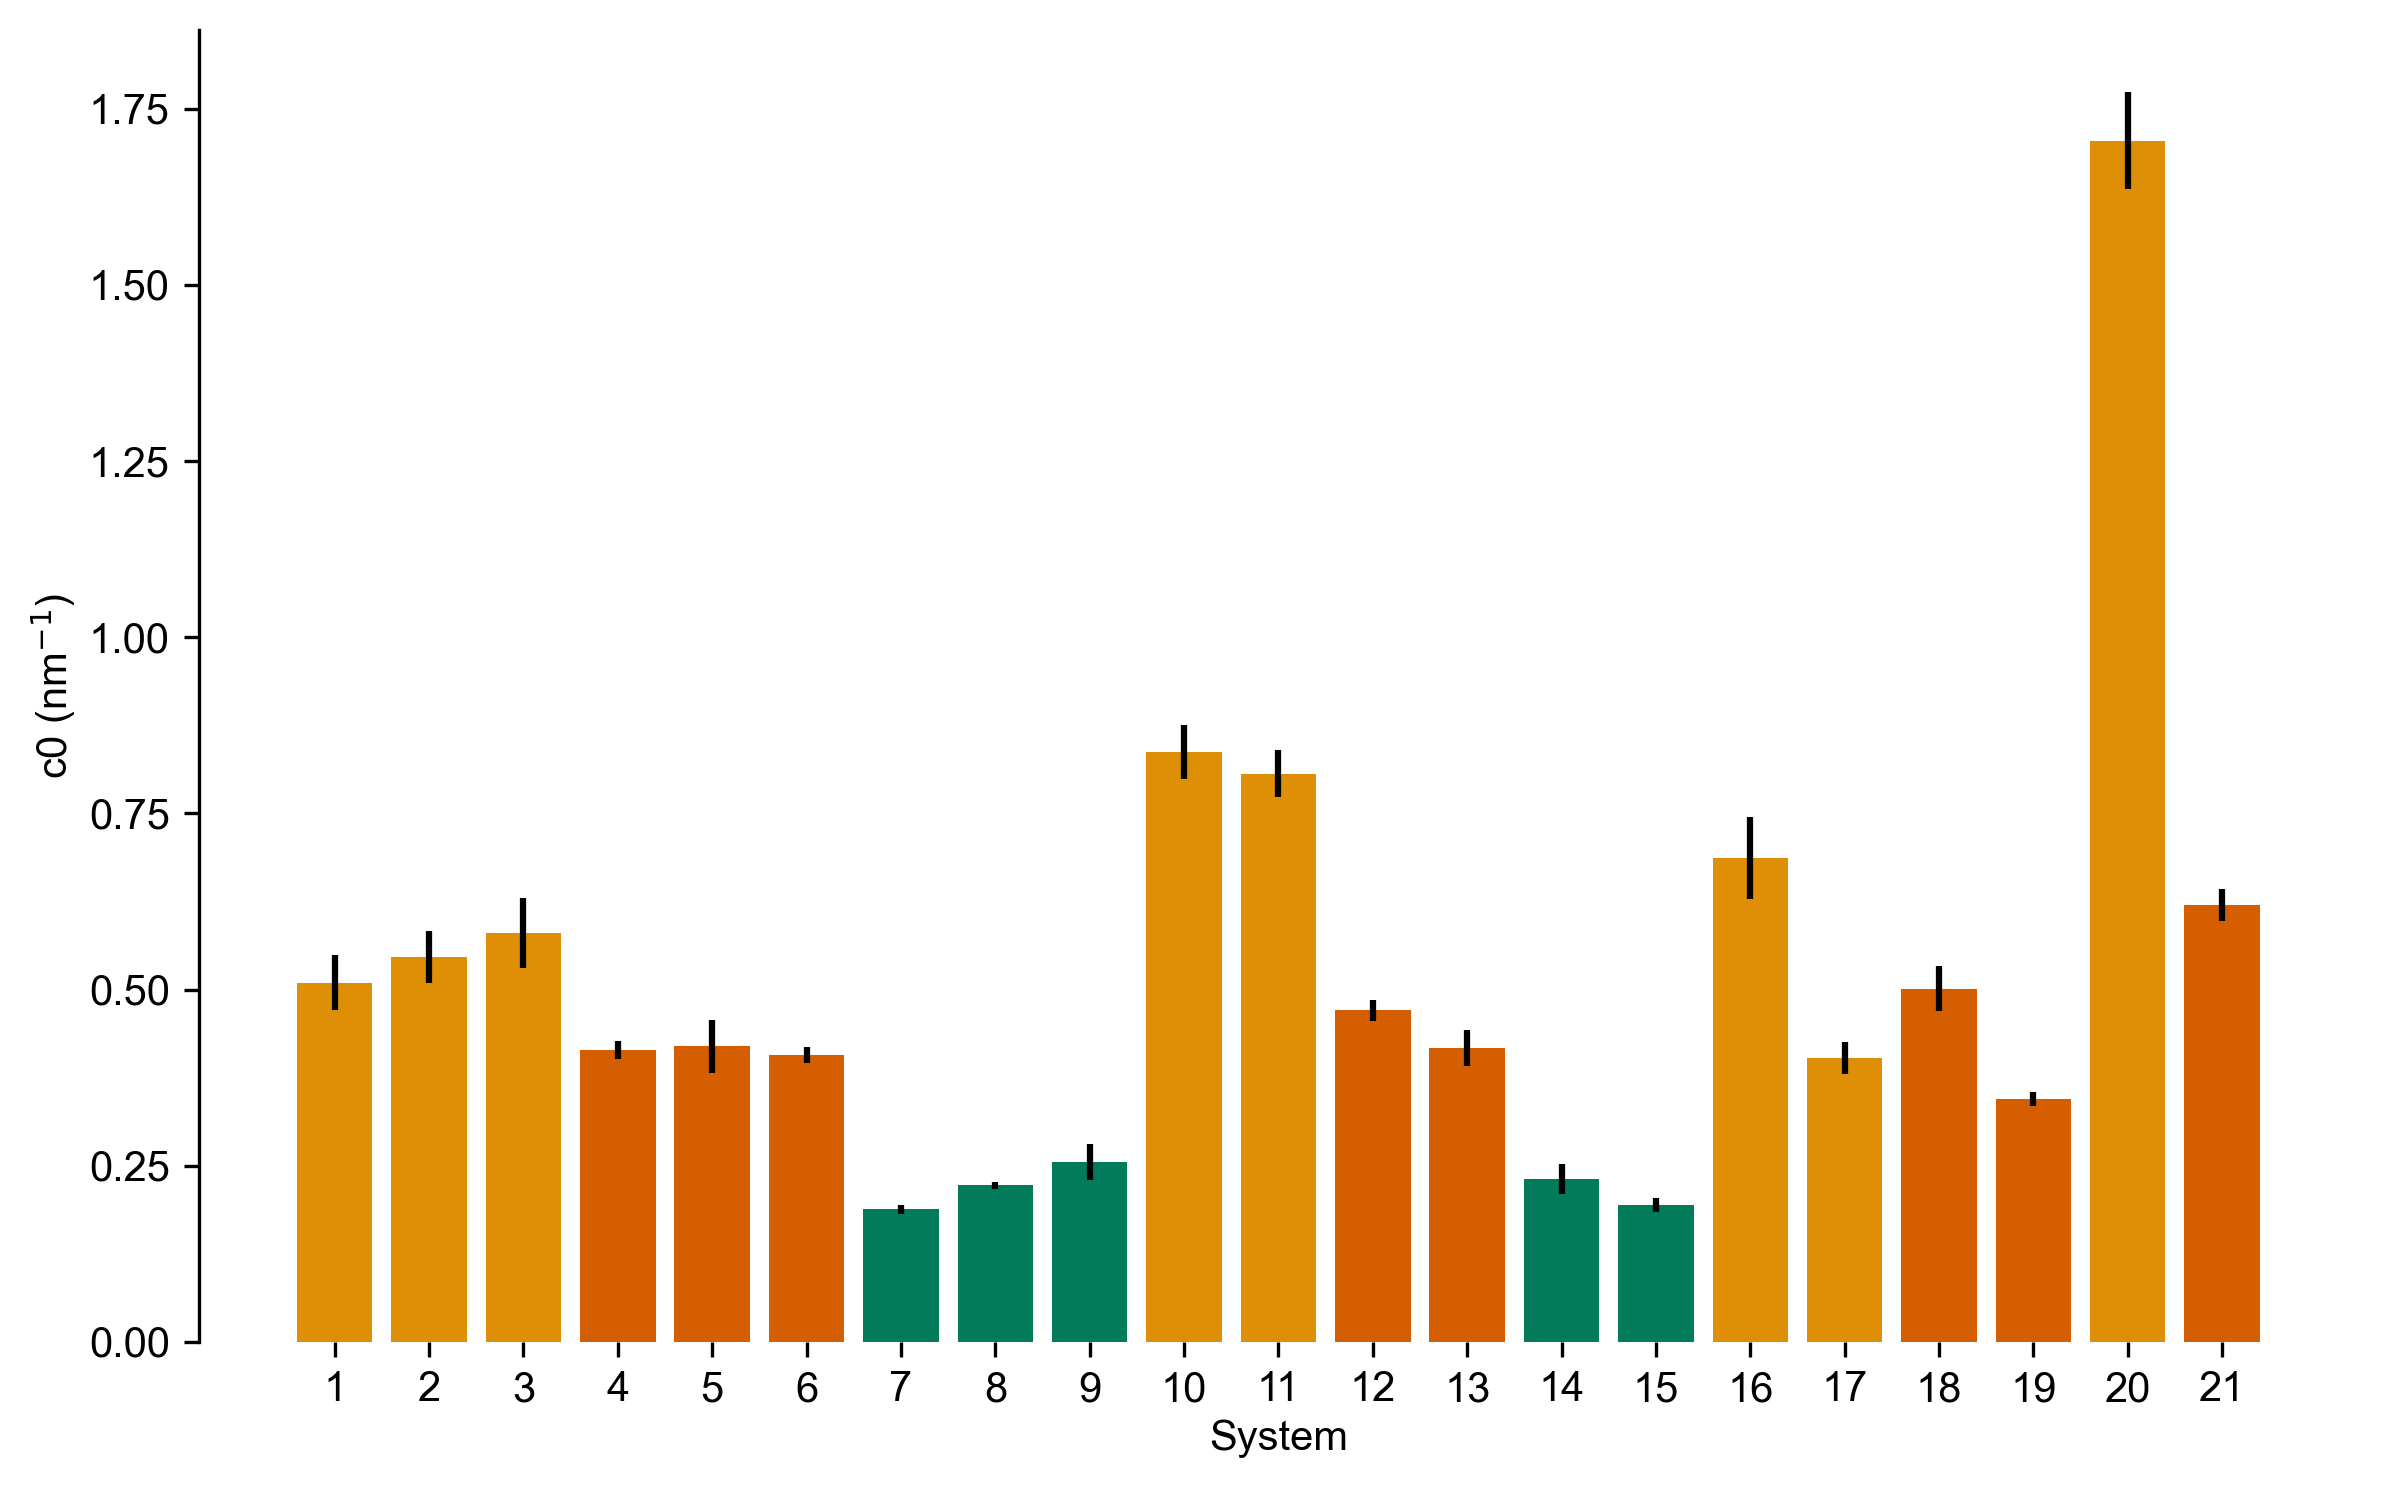

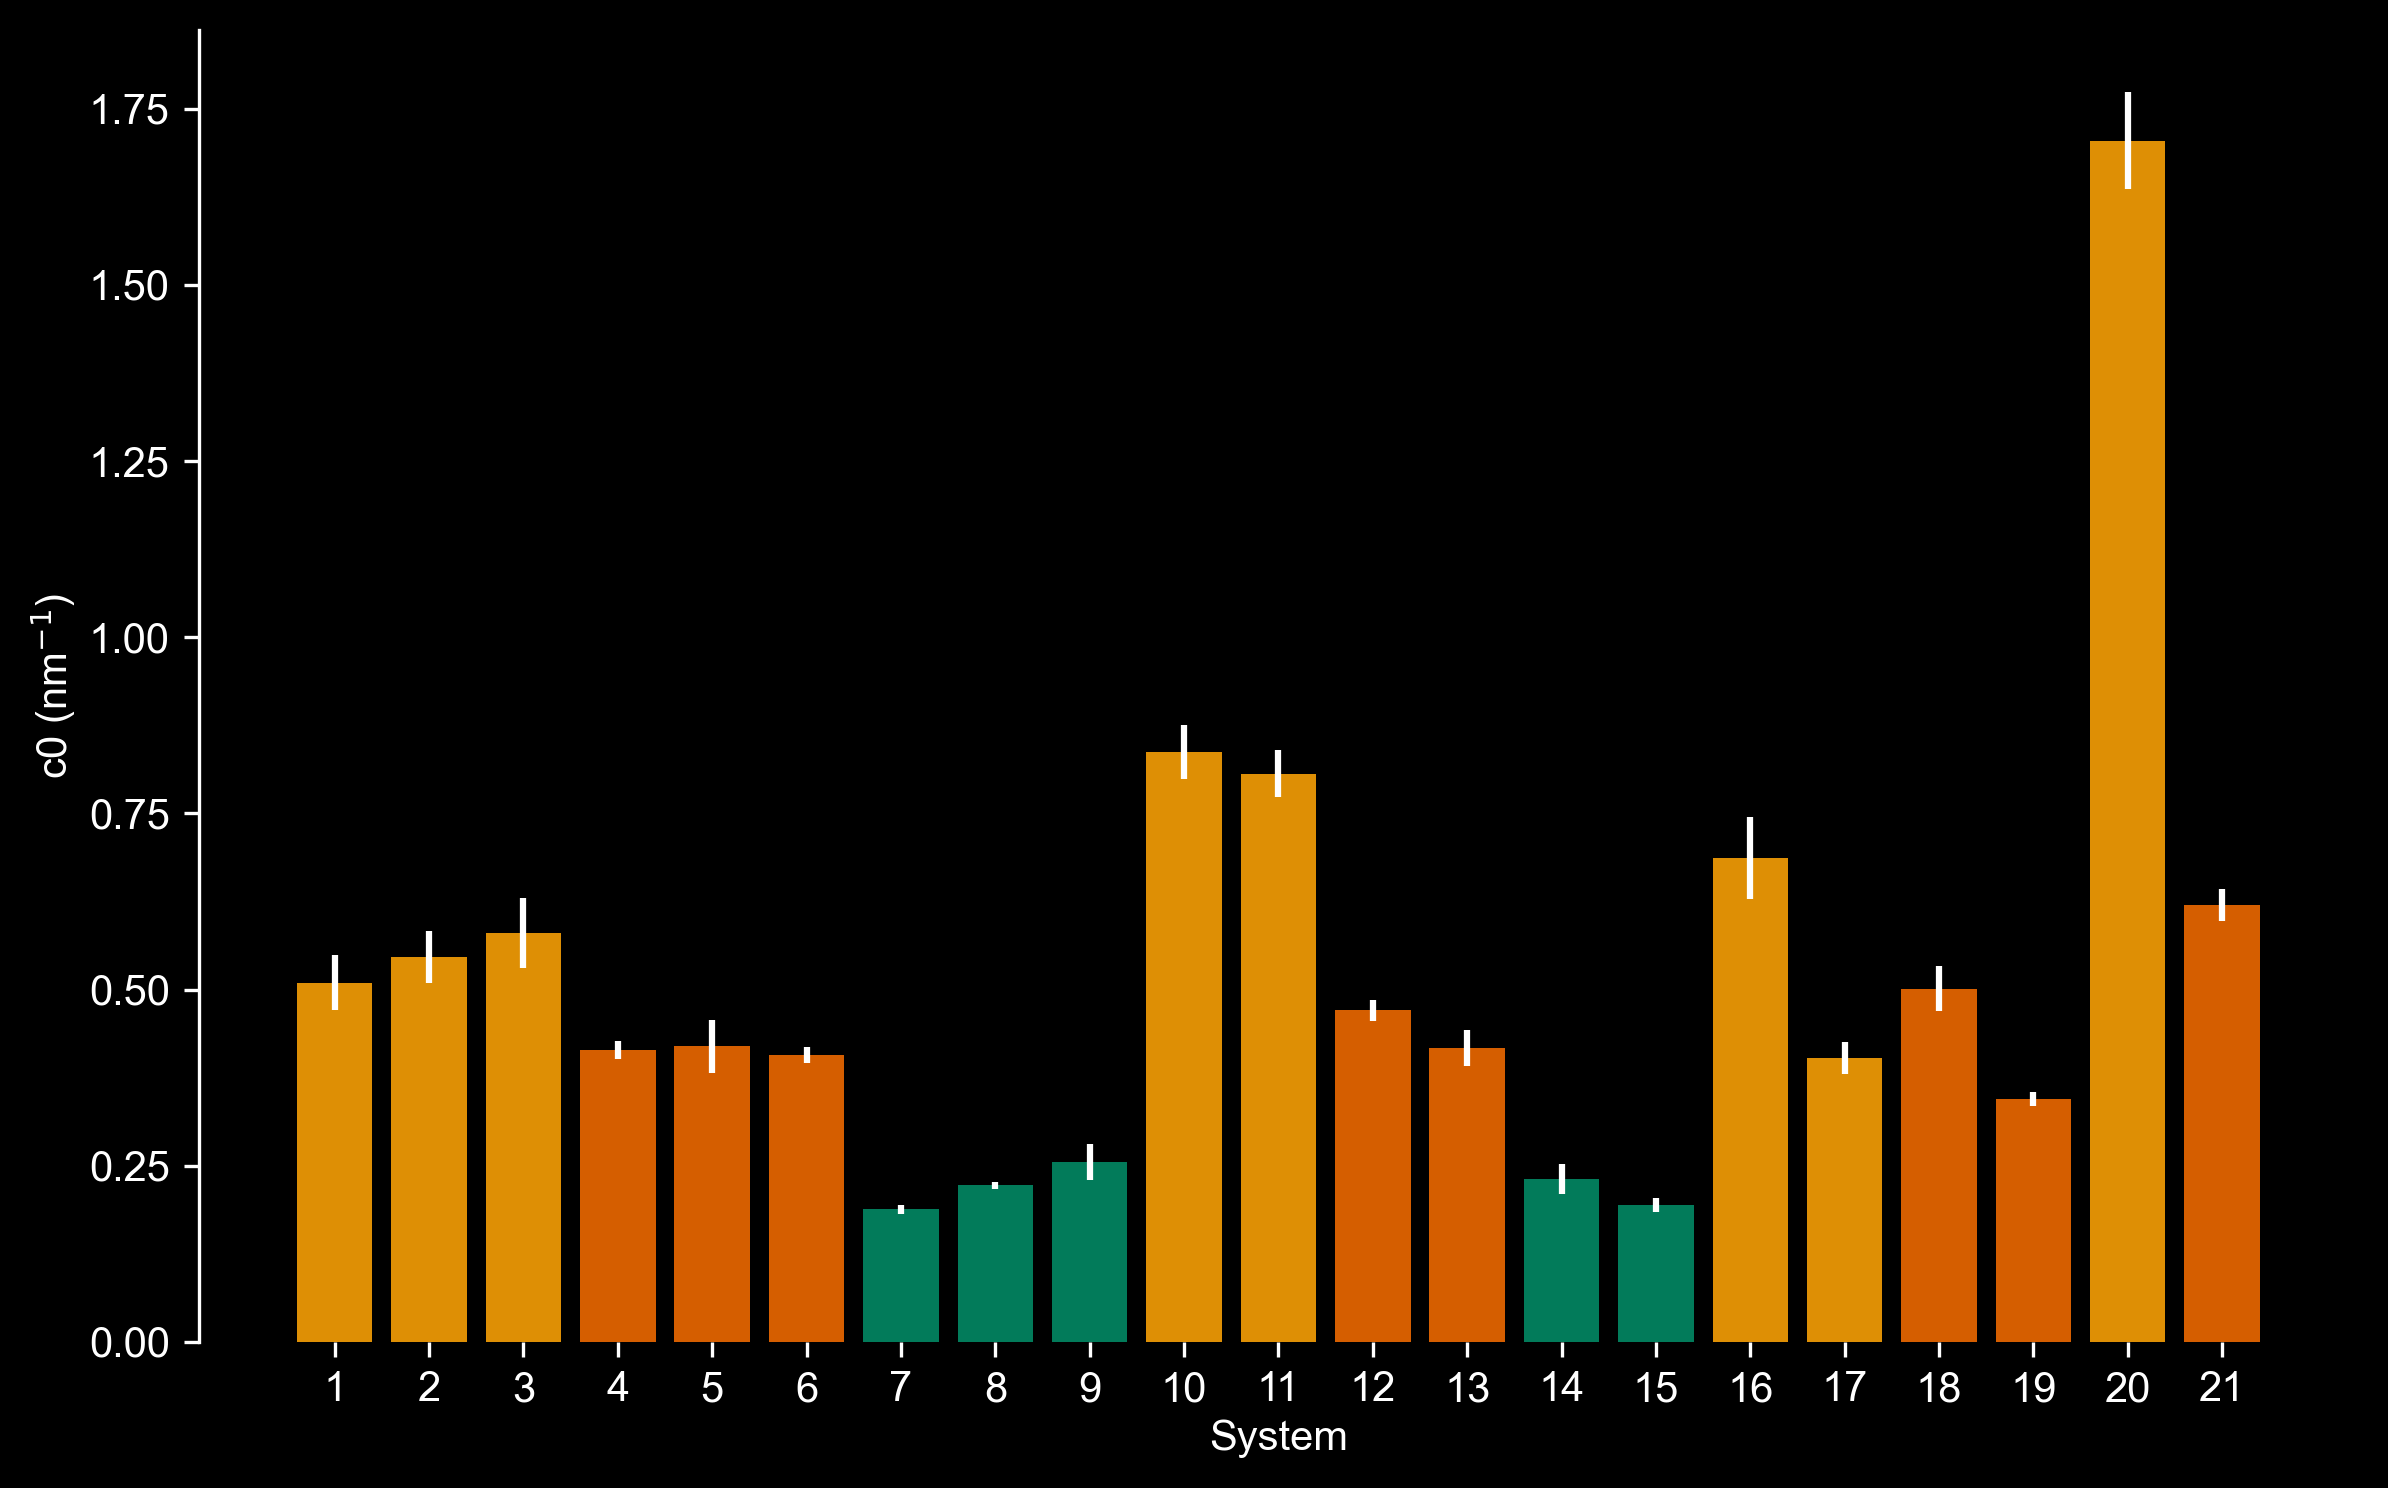

In [20]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))

        for i in range(1, 4):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(10, 12):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        for i in range(16, 18):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            c0[20][0],
            yerr=c0[20][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            c0[21][0],
            yerr=c0[21][1],
            color=pal[3],
            ecolor=ecolor,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"c0 (nm$^{-1}$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature_vertical{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


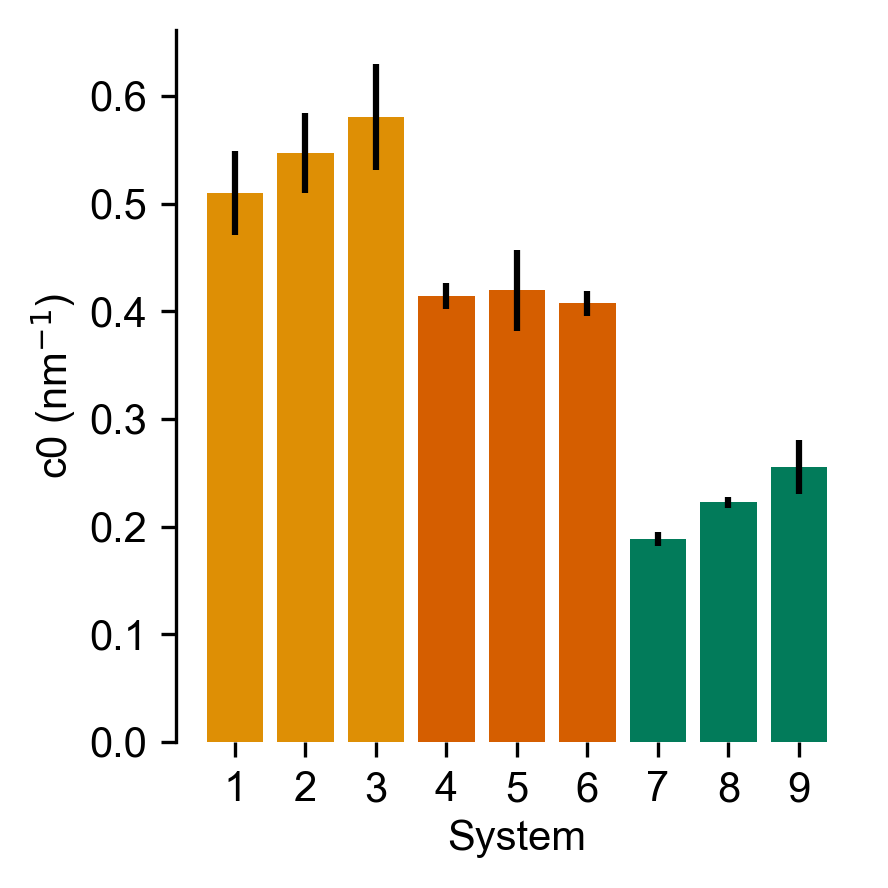

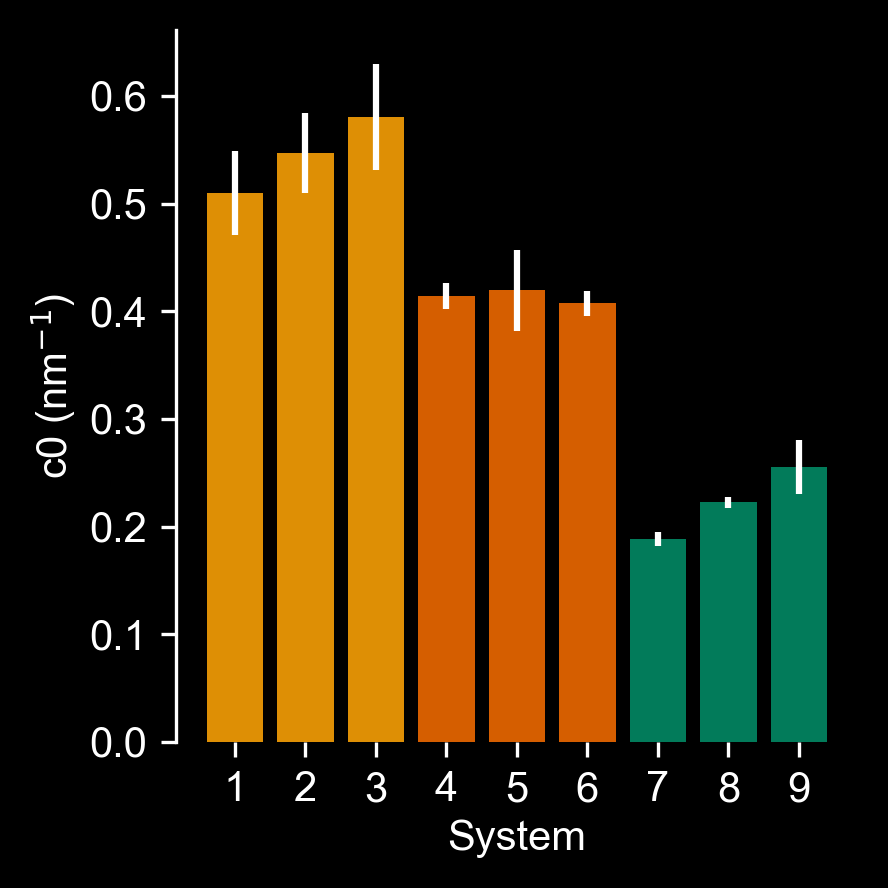

In [21]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        for i in range(1, 4):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(4, 7):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(7, 10):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        # for i in range(10, 12):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )

        # for i in range(12, 14):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # for i in range(14, 16):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )

        # for i in range(16, 18):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )

        # for i in range(18, 20):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # ax.bar("20", c0[20][0], yerr=c0[20][1],color=pal[1], )

        # ax.bar("21", c0[21][0], yerr=c0[21][1],color=pal[3], )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"c0 (nm$^{-1}$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature1-9{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


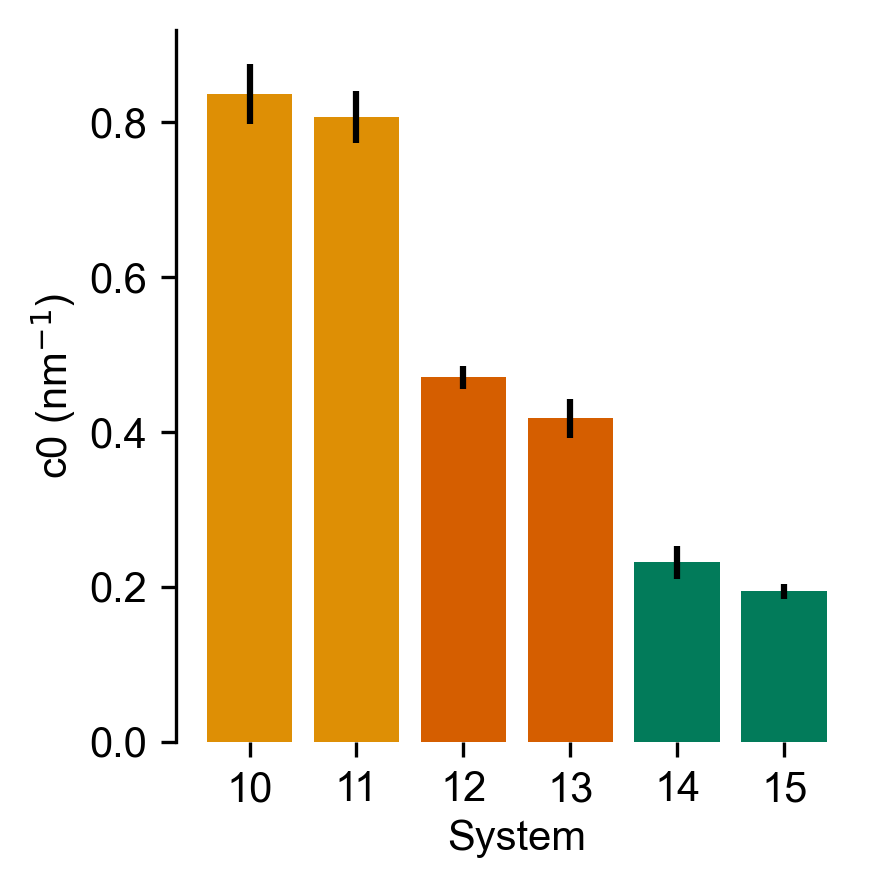

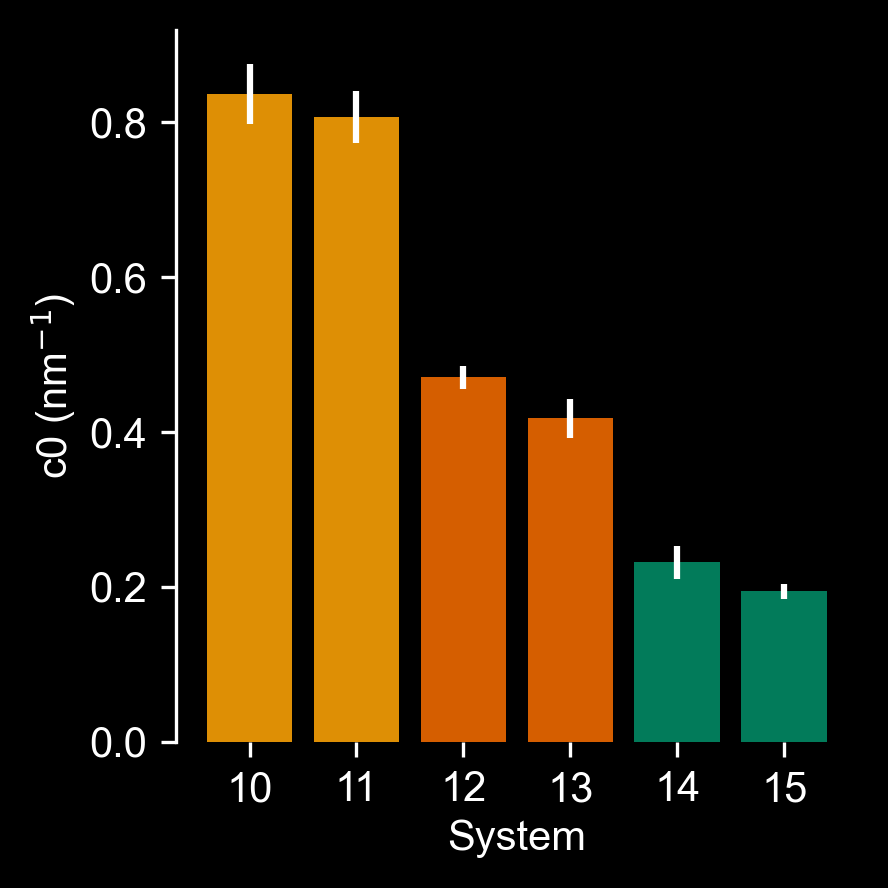

In [22]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        # for i in range(1, 4):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1], color=pal[1], )

        # for i in range(4, 7):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # for i in range(7, 10):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )

        for i in range(10, 12):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(12, 14):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        for i in range(14, 16):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=lighten_color(pal[2], 1.1),
                ecolor=ecolor,
            )

        # for i in range(16, 18):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )

        # for i in range(18, 20):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # ax.bar("20", c0[20][0], yerr=c0[20][1],color=pal[1], )

        # ax.bar("21", c0[21][0], yerr=c0[21][1],color=pal[3], )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"c0 (nm$^{-1}$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature10-15{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


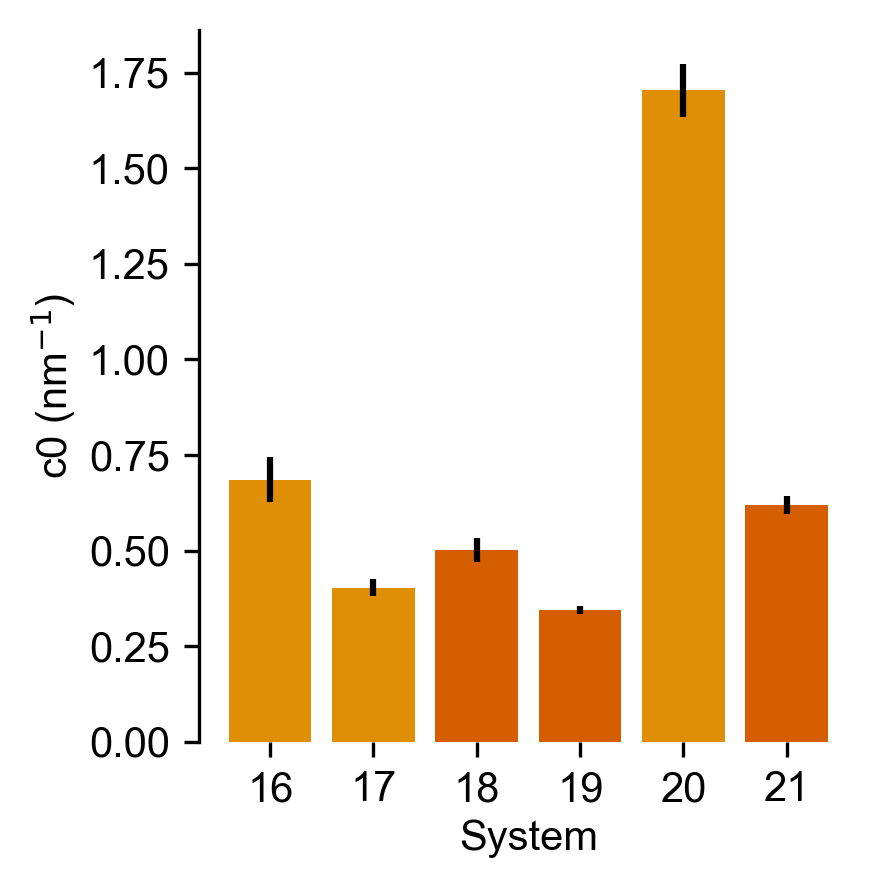

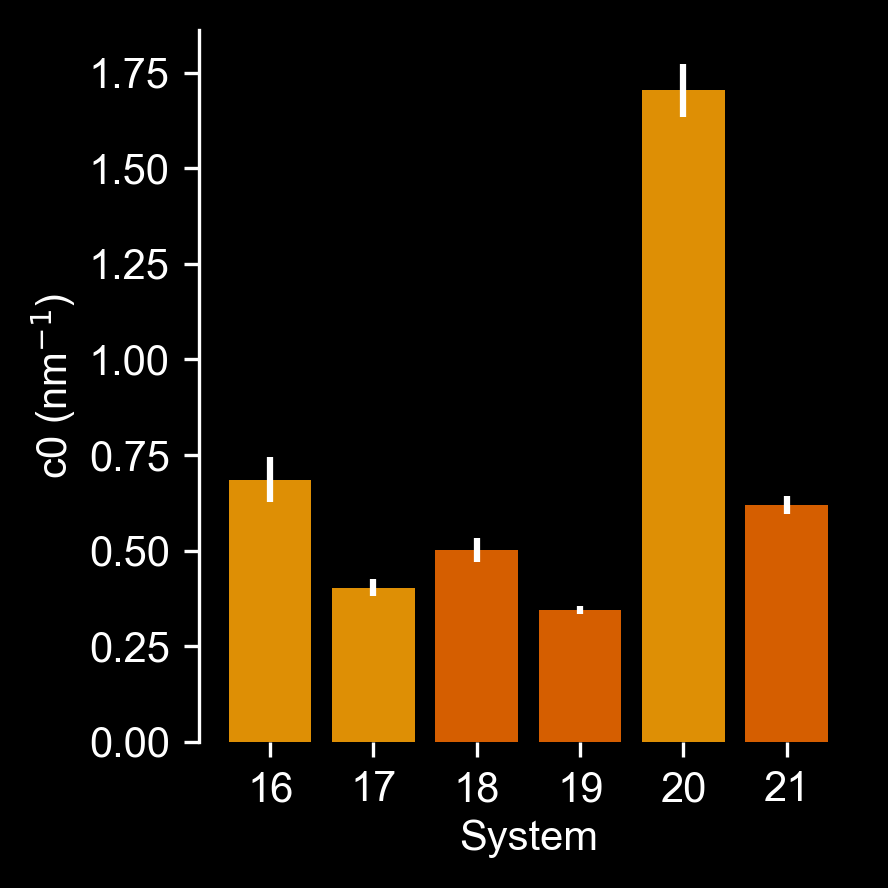

In [23]:
show_figs = True
curr_fig_path = Path("Figures")
curr_fig_path.mkdir(parents=True, exist_ok=True)


for style, style_ext in plot_styles:
    with plt.style.context(style):
        if style_ext:
            ecolor = "white"
        else:
            ecolor = "black"
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))

        # for i in range(1, 4):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1], color=pal[1], )

        # for i in range(4, 7):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # for i in range(7, 10):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )

        # for i in range(10, 12):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[1], )

        # for i in range(12, 14):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=pal[3], )

        # for i in range(14, 16):
        #     ax.bar(str(i), c0[i][0], yerr=c0[i][1],color=lighten_color(pal[2], 1.1), )

        for i in range(16, 18):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[1],
                ecolor=ecolor,
            )

        for i in range(18, 20):
            ax.bar(
                str(i),
                c0[i][0],
                yerr=c0[i][1],
                color=pal[3],
                ecolor=ecolor,
            )

        ax.bar(
            "20",
            c0[20][0],
            yerr=c0[20][1],
            color=pal[1],
            ecolor=ecolor,
        )

        ax.bar(
            "21",
            c0[21][0],
            yerr=c0[21][1],
            color=pal[3],
            ecolor=ecolor,
        )

        # ax.axhline(2.5, color="k")
        # ax.axhline(5.5, color="k")
        # ax.axhline(8.5, color="k")
        # ax.axhline(14.5, color="k")
        # ax.axhline(18.5, color="k")

        ax.set_ylabel(r"c0 (nm$^{-1}$)")
        ax.set_xlabel(r"System")

        # ax.set_xlim(0, 40)

        # ax.set_xticklabels(
        #     ax.get_xticks(),
        # )

        # x_ticks_labels = [f"{sim}" for sim in range(1,22)]

        # Set number of ticks for x-axis
        # ax.set_xticks(range(21))
        # Set ticks labels for x-axis
        # ax.set_xticklabels(x_ticks_labels)

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        # ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)

        fig.tight_layout()

        save_fig(fig, curr_fig_path / f"spontaneous_curvature16-21{style_ext}")

        if show_figs:
            plt.show()

        fig.clear()
        plt.close(fig)


In [24]:
# f_cubic_dat = {}
# z_cubic_dat = {}
# msd_dat = {}

# for sim in util.simulations:
#     try:
#         data = np.mean(lateral_pressure[sim], axis=0)

#         z = data[:, 2]
#         lp = data[:, 1]
#         szz = data[:, 0]

#         fcd = first_cubic_np(z, lp)
#         f_cubic_dat[sim] = (
#             first_cubic_np(z, lp, maxz=0)[0] - first_cubic_np(z, lp, minz=0)[0]
#         ) / 2
#         # print(first_cubic(z, lp, minz=0)[0], first_cubic(z, lp, maxz=0)[0])

#         zcd = zero_cubic_np(z, lp)
#         z_cubic_dat[sim] = zero_cubic_np(z, lp)[0]

#         msd = mean_squared_deviation_np(szz)
#         msd_dat[sim] = msd
#         print(
#             f"{util.system_names[sim]}\n" f"         Zero Moment (pN/nm): {zcd}\n",
#             f"          First Moment (pN): {fcd}\n",
#             f"Monolayer First Moment (pN): {f_cubic_dat[sim]} {first_cubic_np(z, lp, maxz=0)[0]} {first_cubic_np(z, lp, minz=0)[0]}\n",
#             f"                MSD (kPa^2): {msd}\n",
#             f"      Upper Leaflet Tension: {zero_cubic_np(z, lp, minz=0)}\n",
#             f"      Lower Leaflet Tension: {zero_cubic_np(z, lp, maxz=0)}\n",
#         )
#     except Exception as e:
#         print(
#             f"{util.system_names[sim]}\n" f"{e}\n",
#         )
# np.save("f_cubic_dat.npy", f_cubic_dat)
# np.save("z_cubic_dat.npy", z_cubic_dat)
# np.save("msd_dat.npy", msd_dat)
